In [1]:
import numpy as np
import cupy as cp
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib
import gc
gen = cp.random.default_rng()
import time
%matplotlib inline

import os
# os.environ["CUPY_ACCELERATORS"] = "cutensor,cub,python"
# os.environ['CUPY_CUDA_PER_THREAD_DEFAULT_STREAM'] = "0"

In [2]:
# def gillespie(n_ratio, N, M = 1):
#     runs = []
#     for _ in range(M):
#         Ns = [int(n_ratio * N / (n_ratio + 1))]
#         Ns.append(N-Ns[0])
#         g = [1, -1]
#         cumulative = [0]
#         counts = np.array([0, 0]) 
#         r2 = gen.uniform(size = N)
#         for j in range(N):
#             a = [(Ns[i] - counts[i]) / (N - j) for i in range(2)]
#             mu = 0
#             n = r2[j] - a[mu]
#             mu = int(n > 0)

#             cumulative.append(cumulative[-1] + g[mu])
#             counts[mu] += 1
#     runs.append(np.array(cumulative))
#     return runs
# x = gillespie(1,100, 30)
# print(x)

In [3]:
def gillespie(N_m, N_p, M = 1):
    # gen = np.random.default_rng()
    Ns = [[N_m, N_p]]
    N = N_m + N_p
    Ns = cp.array(Ns).T
    g = cp.array([-1, 1])
    cumulative = cp.zeros([N+1,M])
    counts = cp.zeros([2,M])
    r2 = gen.uniform(size = [N+1,M])
    rang = cp.arange(M)
    for j in range(N):
        a = (Ns - counts) / (N-j)
        n = r2[j] - a[0]
        mu = (n > 0) + 0
        cumulative[j+1] = cumulative[j] + g[mu]
        counts[mu, rang] += 1
    return cumulative.T

# def gillespie(n_ratio, N, M = 1):
#     # gen = np.random.default_rng()
#     Ns = [[int(n_ratio * N / (n_ratio + 1))]]
#     Ns[0].append(N-Ns[0][0])
#     Ns = cp.array(Ns).T
#     g = cp.array([1, -1])
#     cumulative = cp.zeros([N+1,M])
#     counts = cp.zeros([2,M])
#     r2 = gen.uniform(size = [N+1,M])
#     rang = cp.arange(M)
#     for j in range(N):
#         a = (Ns - counts) / (N-j)
#         n = r2[j] - a[0]
#         mu = (n > 0) + 0
#         cumulative[j+1] = cumulative[j] + g[mu]
#         counts[mu, rang] += 1
#     return cumulative.T

In [4]:
def null_path(N_m, N_p):
    N = N_m + N_p
    t = np.linspace(0, 1, N + 1)
    return np.arange(N+1) * (N_p - N_m) * t

In [5]:
def empirical_test(n_ratio, N, theta,j, M):
    runs = gillespie(n_ratio, N, M)
    successes = runs[:,j] == theta
    return cp.sum(successes) / M

In [6]:
# testing hypergeometric distribution
N = 100
n_ratio = 1
Np = int(N * n_ratio / (n_ratio + 1))
j = 98
theta = (2 * Np - N) * j / N
print(f'target theta = {theta}')


suc = (theta + j) / 2
if suc % 1 == 0:
    true = sp.special.comb(Np, suc) * sp.special.comb(N - Np, j - suc) / sp.special.comb(N, j)
    print(f'True probability that theta({j}) = {theta} is {np.round(true,4)}')
else:
    true = 0
    print("impossible")

test = empirical_test(n_ratio, N, theta,j, 1000000)
print(f'Sample estimate: {np.round(test,4)}')

target theta = 0.0
True probability that theta(98) = 0.0 is 0.5051
Sample estimate: 0.0


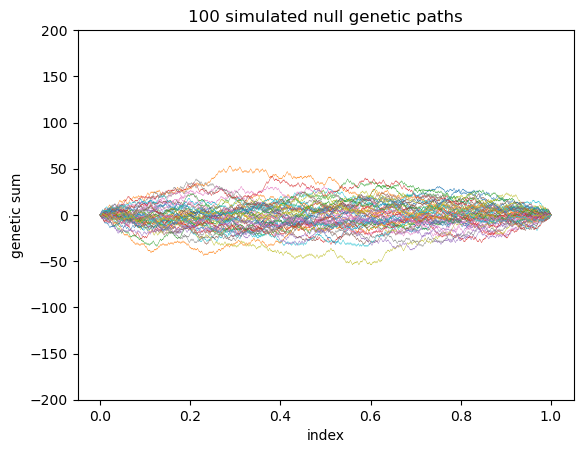

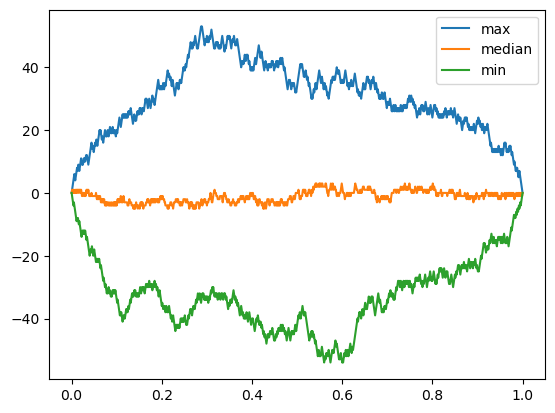

In [7]:
N = 1000
n_ratio = 1
N_m = 500
N_p = 500
M = 50
t = np.linspace(0, 1, N + 1)
x = gillespie(N_m, N_p, M).get()

nullp = null_path(N_m, N_p)
plt.plot(t, (x- nullp).T,linewidth=0.3,alpha=1)
plt.ylim([-200,200])
plt.title("100 simulated null genetic paths")
plt.xlabel("index")
plt.ylabel("genetic sum")
plt.show()


max = np.max(x,axis=0)
min = np.min(x,axis=0)
med = np.median(x,axis=0)
plt.plot(t, max,label="max")
plt.plot(t, med,label="median")
plt.plot(t, min,label="min")
plt.legend()
plt.show()

In [8]:
# find empirical distribution of intersection locations (with null path) and number of intersections
def intersection_density(N_m, N_p, M): 
    N = N_p + N_m
    x0 = cp.arange(N+1) * (N_p - N_m) / N
    intersections = cp.zeros([M,N+1])
    x = gillespie(N_m, N_p, M)
    y = x - x0
    intersections = y == 0

    inter_number = cp.sum(intersections[:], axis = 1) - 1
    inters = cp.argwhere(intersections == 1).T[1] / N

    return inters.get(), inter_number.get()

# def intersection_density(n_ratio, N, M): 
#     Ns = [int(n_ratio * N / (n_ratio + 1))]
#     Ns.append(N-Ns[0])
#     x0 = cp.arange(N+1) * (Ns[0] - Ns[1]) / N
#     intersections = cp.zeros([M,N+1])
#     x = gillespie(n_ratio, N, M)
#     y = x - x0
#     # intersections[:,1:] = y[:,1:] == 0
#     intersections = y == 0

#     inter_number = cp.sum(intersections, axis = 1)
#     inters = cp.argwhere(intersections == 1).T[1] / N

#     return inters.get(), inter_number.get()

In [ ]:
def intersect_num_dp(N_m, N_p, J=-1, K=-1):

    def f(N, N_p, ind, theta):
        n_p = (ind + theta) / 2
        return sp.stats.hypergeom.pmf(k=n_p, N=ind, n=N_p, M=N)
    
    N = N_m + N_p
    d = np.gcd(N,N_p)
    a = int(N / d)
    if J == -1:
        J = N
    if K == -1:
        K = d
    J = int(J/a)

    # we define probs[j,k,l] = p(z_j = k, theta(aj) = l)
    
    probs = np.zeros([J+1, J+1, N + 1])
    probs[0,0,0] = 1
    null = (N_p - N_m) / N
    
    starttime = time.time()
    # for k = 0
    for j in range(1,J+1):
        ja = j * a
        N_sub = N - a * (j-1)
        for s in range(np.max([-ja, -N_m]), np.min([ja, N_p])+1):
            if s / ja == (N_p - N_m) / N:
                continue
            pcurr = 0
            for l in range(np.max([s-a, -(ja - a), -N_m]), np.min([s+a, ja - a, N_p])+1):
                N_sub_p = N_p - (l + ja - a) / 2
                if N_sub_p %1 != 0:
                    continue
                if N_sub_p > N_sub or N_sub_p < 0:
                    continue
                step = f(N_sub, N_sub_p, a, s-l)
                pcurr += probs[j-1,0,l] * step
                if pcurr != pcurr:
                    print(N_sub_p, N_sub)
                    print("fail, jsl:", j, s, l)
                    print("p,step:", probs[j-1,0,l], step)
                # print(j,s,l,probs[j-1,0,l], step, "jslp, step, pcurr")
            
            probs[j,0,s] = pcurr

            # print(j,0,s)
            # print(pcurr, "pcurr", probs[j,0,s])
    firstloop = time.time()
    print("Time to complete first loop: ", firstloop - starttime)

    # for k in range(1,K+1):
    #     for j in range(k,J+1):
    
    for j in range(1,J+1):
        for k in range(1, j+1):
            ja = j* a
            N_sub = N - a * (j-1)
            for s in range(np.max([-ja, -N_m]), np.min([ja, N_p])+1):
                pcurr = 0
                for l in range(np.max([s-a, -(ja - a), -N_m]), np.min([s+a, ja - a, N_p])+1):
                    N_sub_p = N_p - (l + ja - a) / 2
                    if N_sub_p %1 != 0:
                        continue
                    if N_sub_p > N_sub or N_sub_p < 0:
                        continue
                    step = f(N_sub, N_sub_p, a, s-l)

                    if s / ja == null:
                        pcurr += probs[j-1,k-1,l] * step
                    else:
                        pcurr += probs[j-1,k,l] * step

                    if pcurr != pcurr:
                        print(N_sub_p, N_sub)
                        print("fail, jsl:", j, s, l)
                        print("p,step:", probs[j-1,k,l], step)
                        print("pcurr:", pcurr)
                    # print(j,s,l,probs[j-1,0,l], step, "jslp, step, pcurr")
                probs[j,k,s] = pcurr
    
    secondloop = time.time()
    print("Time to complete first loop: ", secondloop - firstloop)
    ptot = np.sum(probs, axis = 2)
    # return np.concatenate([np.array([0]), ptot[-1]], axis = 0)
    return ptot[-1]

N_m = 25
N_p = 25

d = np.gcd(N_m, N_p)
a = (N_m + N_p) / d

M = 1000000
_, intnums = intersection_density(N_m, N_p, M)
y = np.unique_counts(intnums)[1]/M
print(y)

x = intersect_num_dp(N_m, N_p)
print(x[1:len(y)+1])

[2.04700e-02 4.13360e-02 5.98760e-02 7.63570e-02 8.95960e-02 9.70220e-02
 1.00053e-01 9.82090e-02 9.17440e-02 8.08880e-02 6.88960e-02 5.50510e-02
 4.23340e-02 3.02910e-02 2.02990e-02 1.29880e-02 7.53500e-03 3.96400e-03
 1.92100e-03 7.55000e-04 2.96000e-04 9.30000e-05 2.30000e-05 3.00000e-06]
Time to complete first loop:  0.10162138938903809
Time to complete first loop:  1.5394413471221924
[2.04081633e-02 4.08163265e-02 5.99218411e-02 7.64220582e-02
 8.91590679e-02 9.72644377e-02 1.00280389e-01 9.82338507e-02
 9.16449949e-02 8.14622176e-02 6.89295688e-02 5.54075003e-02
 4.21795835e-02 3.02827779e-02 2.03945239e-02 1.27965640e-02
 7.41619051e-03 3.92621851e-03 1.87163821e-03 7.88058195e-04
 2.85331415e-04 8.54053216e-05 1.98416404e-05 3.18528006e-06]


In [ ]:
# 0.00000000e+00 2.04081633e-02 4.08163265e-02 5.99218411e-02
#  7.64220582e-02 8.91590679e-02 9.72644377e-02 1.00280389e-01
#  9.82338507e-02 9.16449949e-02 8.14622176e-02 6.89295688e-02
#  5.54075003e-02 4.21795835e-02 3.02827779e-02 2.03945239e-02
#  1.27965640e-02 7.41619051e-03 3.92621851e-03 1.87163821e-03
#  7.88058195e-04 2.85331415e-04 8.54053216e-05 1.98416404e-05
#  3.18528006e-06]

In [ ]:
def intersect_num_dp(N_m, N_p, J=-1, K=-1):

    def f(N, N_p, ind, theta):
        n_p = (ind + theta) / 2
        return sp.stats.hypergeom.pmf(k=n_p, N=ind, n=N_p, M=N)
    
    N = N_m + N_p
    d = np.gcd(N,N_p)
    a = int(N / d)
    if J == -1:
        J = N
    if K == -1:
        K = d
    J = int(J/a)

    # we define probs[j,l,k] = p(z_j = k, theta(aj) = l)
    
    probs = np.zeros([J+1, N + 1, J+1])
    probs[0,0,0] = 1
    null = (N_p - N_m) / N
    
    starttime = time.time()
    # for k = 0
    for j in range(1,J+1):
        ja = j * a
        N_sub = N - a * (j-1)
        for s in range(np.max([-ja, -N_m]), np.min([ja, N_p])+1):
            if s / ja == (N_p - N_m) / N:
                continue
            pcurr = 0
            for l in range(np.max([s-a, -(ja - a), -N_m]), np.min([s+a, ja - a, N_p])+1):
                N_sub_p = N_p - (l + ja - a) / 2
                if N_sub_p %1 != 0:
                    continue
                if N_sub_p > N_sub or N_sub_p < 0:
                    continue
                step = f(N_sub, N_sub_p, a, s-l)
                pcurr += probs[j-1,l, 0] * step
                if pcurr != pcurr:
                    print(N_sub_p, N_sub)
                    print("fail, jsl:", j, s, l)
                    print("p,step:", probs[j-1,l, 0], step)
                # print(j,s,l,probs[j-1,0,l], step, "jslp, step, pcurr")
            
            probs[j,s,0] = pcurr

            # print(j,0,s)
            # print(pcurr, "pcurr", probs[j,0,s])
    firstloop = time.time()
    print("Time to complete first loop: ", firstloop - starttime)

    # for k in range(1,K+1):
    #     for j in range(k,J+1):
    
    for j in range(1,J+1):
        ja = j * a
        N_sub = N - a * (j-1)
        for s in range(np.max([-ja, -N_m]), np.min([ja, N_p])+1):
            pcurr = 0
            for k in range(1, j+1):
                for l in range(np.max([s-a, -(ja - a), -N_m]), np.min([s+a, ja - a, N_p])+1):
                    N_sub_p = N_p - (l + ja - a) / 2
                    if N_sub_p %1 != 0:
                        continue
                    if N_sub_p > N_sub or N_sub_p < 0:
                        continue
                    step = f(N_sub, N_sub_p, a, s-l)
                    
                    if s / ja == null:
                        pcurr += probs[j-1,l,k-1] * step
                    else:
                        pcurr += probs[j-1,l,k] * step
                probs[j,s,k] = pcurr
                # if pcurr != pcurr:
                #     print(N_sub_p, N_sub)
                #     print("fail, jsl:", j, s, l)
                #     print("p,step:", probs[j-1,k,l], step)
                #     print("pcurr:", pcurr)

                # print(j,s,l,probs[j-1,0,l], step, "jslp, step, pcurr")
            
    
    secondloop = time.time()
    print("Time to complete first loop: ", secondloop - firstloop)
    ptot = np.sum(probs[-1], axis = 0)
    # return np.concatenate([np.array([0]), ptot[-1]], axis = 0)
    return ptot


N_m = 25
N_p = 25

d = np.gcd(N_m, N_p)
a = (N_m + N_p) / d

M = 1000000
_, intnums = intersection_density(N_m, N_p, M)
y = np.unique_counts(intnums)[1]/M
print(y, "\n")
x = intersect_num_dp(N_m, N_p)
print(x[1:len(y)+1])

[2.03670e-02 4.06680e-02 6.06040e-02 7.66670e-02 8.92760e-02 9.73550e-02
 1.00104e-01 9.81820e-02 9.12430e-02 8.16590e-02 6.88110e-02 5.49990e-02
 4.24650e-02 3.02500e-02 2.04200e-02 1.27170e-02 7.32300e-03 3.88700e-03
 1.83400e-03 7.69000e-04 2.89000e-04 9.00000e-05 1.80000e-05 3.00000e-06] 

Time to complete first loop:  0.10011744499206543
Time to complete first loop:  1.4824919700622559
[2.04081633e-02 6.12244898e-02 6.20495007e-01 6.91315112e+00
 5.97796315e+01 4.12219374e+02 2.37191377e+03 1.17811745e+04
 5.17647130e+04 2.04882406e+05 7.40603228e+05 2.47132564e+06
 7.67740962e+06 2.23548665e+07 6.13398261e+07 1.59284419e+08
 3.92713042e+08 9.21389375e+08 2.05984010e+09 4.38818814e+09
 8.89489279e+09 1.70869614e+10 3.08447172e+10 5.13770505e+10]


In [ ]:
# [2.04081633e-02 4.08163265e-02 5.99218411e-02 7.64220582e-02
#  8.91590679e-02 9.72644377e-02 1.00280389e-01 9.82338507e-02
#  9.16449949e-02 8.14622176e-02 6.89295688e-02 5.54075003e-02
#  4.21795835e-02 3.02827779e-02 2.03945239e-02 1.27965640e-02
#  7.41619051e-03 3.92621851e-03 1.87163821e-03 7.88058195e-04
#  2.85331415e-04 8.54053216e-05 1.98416404e-05 3.18528006e-06]

# [0.00000000e+00 1.08554060e-02 2.17108120e-02 3.18425242e-02
#  4.05268490e-02 4.71242431e-02 5.11634639e-02 5.24113533e-02
#  5.09138860e-02 4.69974333e-02 4.12258186e-02 3.43177085e-02
#  2.70381946e-02 2.00855160e-02 1.39962419e-02 9.08846876e-03
#  5.45308126e-03 2.99039940e-03 1.47760912e-03 6.45392487e-04
#  2.42628755e-04 7.54845014e-05 1.82490003e-05]

In [51]:
# # for nr = 2
# def intersect_num_dp(N,k,l = -1):
#     '''Assume N+ = N-'''
#     if l == -1:
#         l = N
#     if l % 2 != 0:
#         print("non-int")

#     def f(N,c,a):
#         return (1 / ((a - c)*2 - 1)) * sp.special.comb((N - c * 2)/ 2, a-c) ** 2 / sp.special.comb(N - 2 * c, 2 * (a-c))

#     dp = np.zeros([int(l/2)+1, k]) # P j_b = a n_r
#     dp[0,0] = 1
#     dp[1,1] = sp.special.comb(N / 2, 1) * sp.special.comb(N / 2, 1) / sp.special.comb(N, 2)
#     for i in range(2, int(l/2)+1):
#         for b in range(1,k):
#             if b <= i:
#                 x = [dp[c,b-1] * f(N, c, i) for c in range(i)]
#                 dp[i,b] = np.sum(x)
#     dp = np.concatenate([np.zeros([int(l/2 + 1),1]),dp],axis=1)
#     return dp[-1]

# d = intersect_num_dp(300,50)
# print(d)

In [52]:
# runs = []
# del runs
# cp._default_memory_pool.free_all_blocks()

# n_ratios = [i for i in range(1,6)]
# N1 = [i * 300 for i in range(1,4)]
# M = 20000
# runs = []
# for N in N1:
#     runs.append([])
#     for n_ratio in n_ratios:
#         runs[-1].append(intersection_density(n_ratio, N, M))

In [53]:
def null_intersection_exact(N_m, N_p):
    N = N_p + N_m
    probs = []
    for j in range(N+1):
        prob = float(sp.stats.hypergeom.pmf(k=j * N_p / N, N=j, n=N_p, M=N))
        probs.append(prob)
    return probs

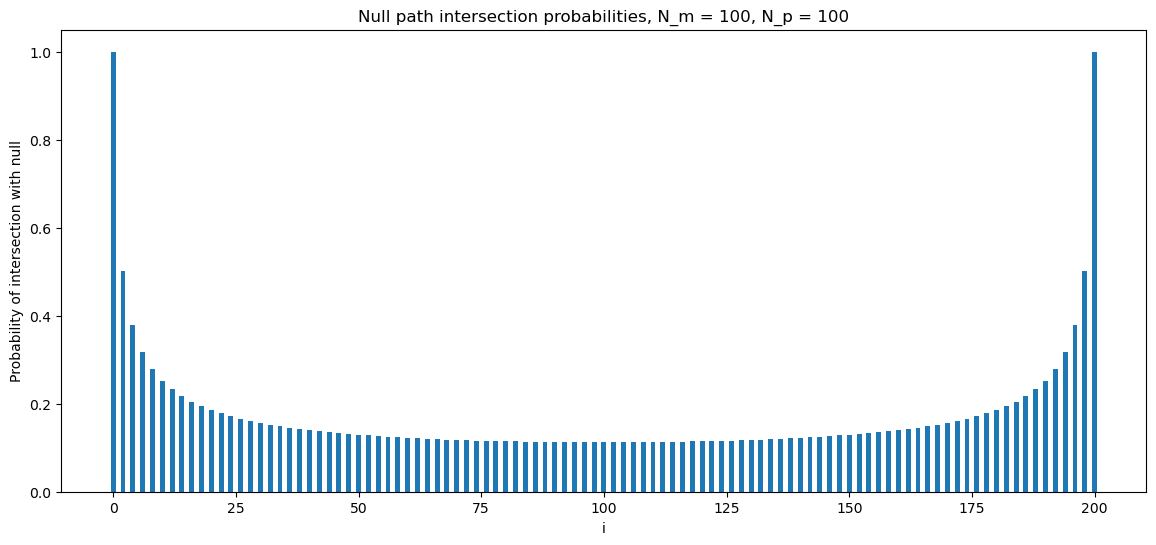

In [54]:
N_m = 100
N_p = 100
N = N_m + N_p

probs = null_intersection_exact(N_m, N_p)

x = np.arange(N+1)

fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(6)
ax.set_title(f"Null path intersection probabilities, N_m = {N_m}, N_p = {N_p}")
ax.set_ylabel("Probability of intersection with null")
ax.set_xlabel("i")
ax.bar(x, probs, width = 1)
plt.show()

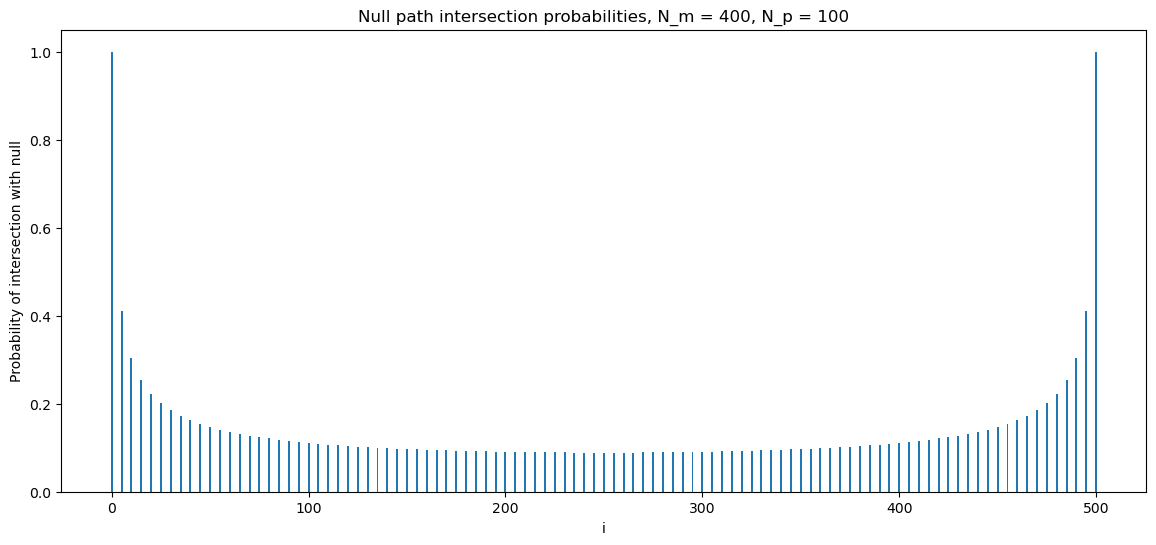

In [55]:
N_m = 400
N_p = 100
N = N_m + N_p

probs = null_intersection_exact(N_m, N_p)

x = np.arange(N+1)

fig, ax = plt.subplots()
fig.set_figwidth(14)
fig.set_figheight(6)
ax.set_title(f"Null path intersection probabilities, N_m = {N_m}, N_p = {N_p}")
ax.set_ylabel("Probability of intersection with null")
ax.set_xlabel("i")
ax.bar(x, probs, width = 1)
plt.show()

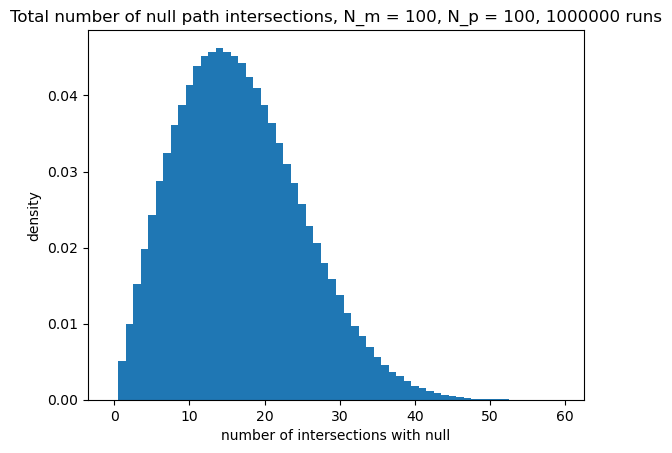

In [56]:
N_m = 100
N_p = 100
N = N_m + N_p
M = 1000000

_, inter_number = intersection_density(N_m, N_p, M)

fig, ax = plt.subplots()
ax.hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
ax.set_title(f"Total number of null path intersections, N_m = {N_m}, N_p = {N_p}, {M} runs")
ax.set_xlabel("number of intersections with null")
ax.set_ylabel("density")
plt.show()

Time to complete first loop:  3.0989270210266113
Time to complete first loop:  4.006241083145142


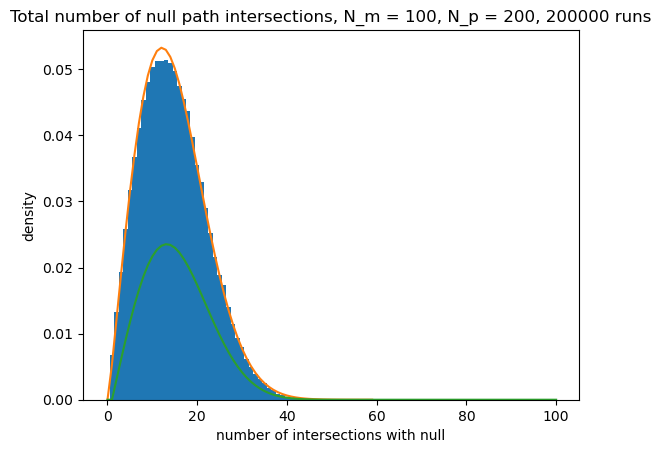

In [57]:
N_m = 100
N_p = 200
N = N_m + N_p
M = 200000

_, inter_number = intersection_density(N_m, N_p, M)
fit_alpha, fit_loc, fit_beta = sp.stats.weibull_min.fit(inter_number)

fig, ax = plt.subplots()
ax.hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
ax.set_title(f"Total number of null path intersections, N_m = {N_m}, N_p = {N_p}, {M} runs")
ax.set_xlabel("number of intersections with null")
ax.set_ylabel("density")
pred1 = intersect_num_dp(N_m, N_p, K=30)
t = np.arange(60)
pred = sp.stats.weibull_min.pdf(t, fit_alpha, fit_loc, fit_beta)
ax.plot(t, pred)
ax.plot(pred1)



plt.show()

UFuncTypeError: ufunc 'gcd' did not contain a loop with signature matching types (<class 'numpy.dtypes._PyFloatDType'>, <class 'numpy.dtypes._PyLongDType'>) -> None

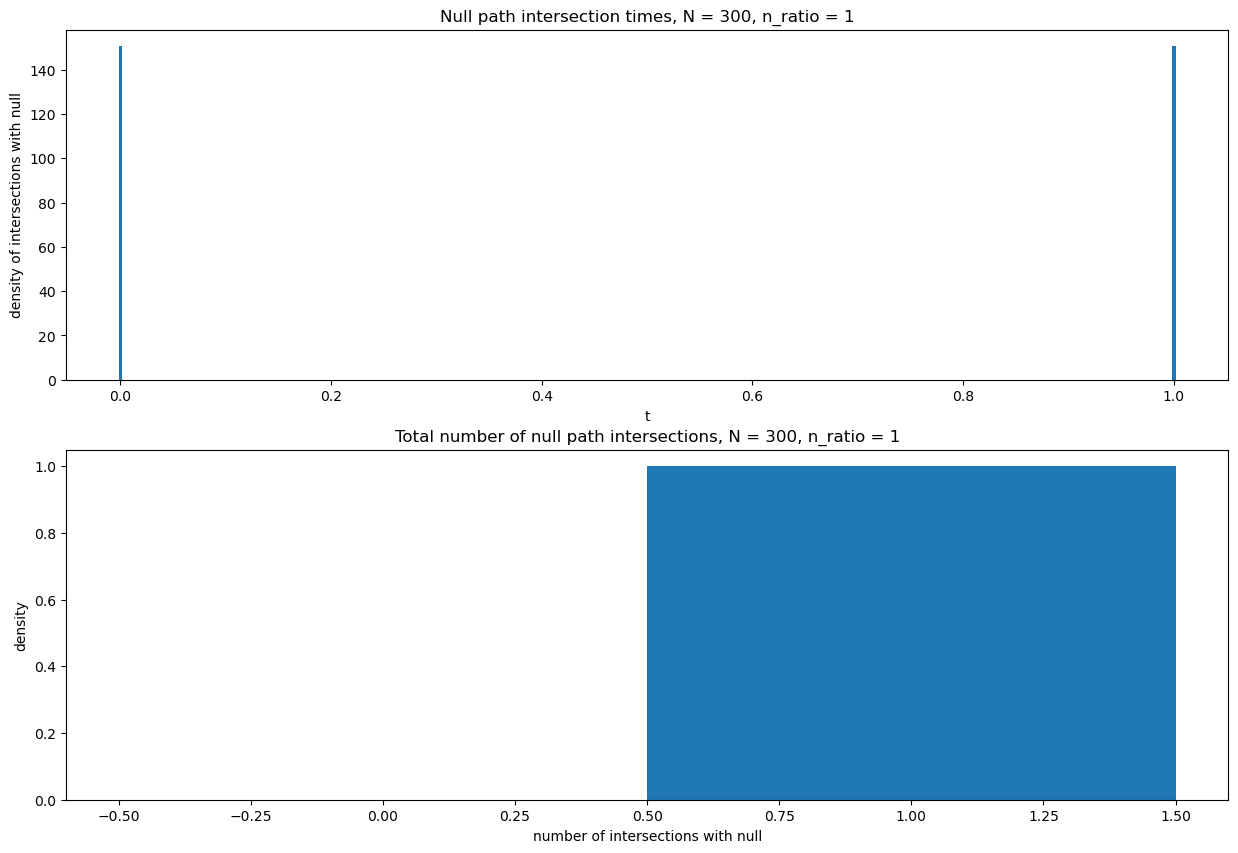

In [30]:
inters, inter_number = [],[]
del inters, inter_number
cp._default_memory_pool.free_all_blocks()

# d = intersect_num_dp(300,50)
gc.collect()

n_ratios = [i for i in range(1,6)]
N1 = [i * 300 for i in range(1,5)]
M = 20000


for i in range(len(N1)):
    for j in range(len(n_ratios)):
        
        N = N1[i]
        n_ratio = n_ratios[j]
        # inters, inter_number = runs[i][j]
        inters, inter_number = intersection_density(n_ratio, N, M)
        
        fig, axs = plt.subplots(2,1)
        fig.set_figwidth(15)
        fig.set_figheight(10)
        axs[0].hist(inters, bins = N+2, density = True, range = [- 0.5 / N, 1 + 0.5/N])
        axs[0].set_title(f"Null path intersection times, N = {N}, n_ratio = {n_ratio}")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("density of intersections with null")
        axs[1].hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
        axs[1].set_title(f"Total number of null path intersections, N = {N}, n_ratio = {n_ratio}")
        axs[1].set_xlabel("number of intersections with null")
        axs[1].set_ylabel("density")
        

        axs[1].plot(np.arange(51), intersect_num_dp(N / n_ratio, 50))
        plt.show()

        del inters, inter_number
        gc.collect()
        cp._default_memory_pool.free_all_blocks()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (301,) and arg 1 with shape (241,).

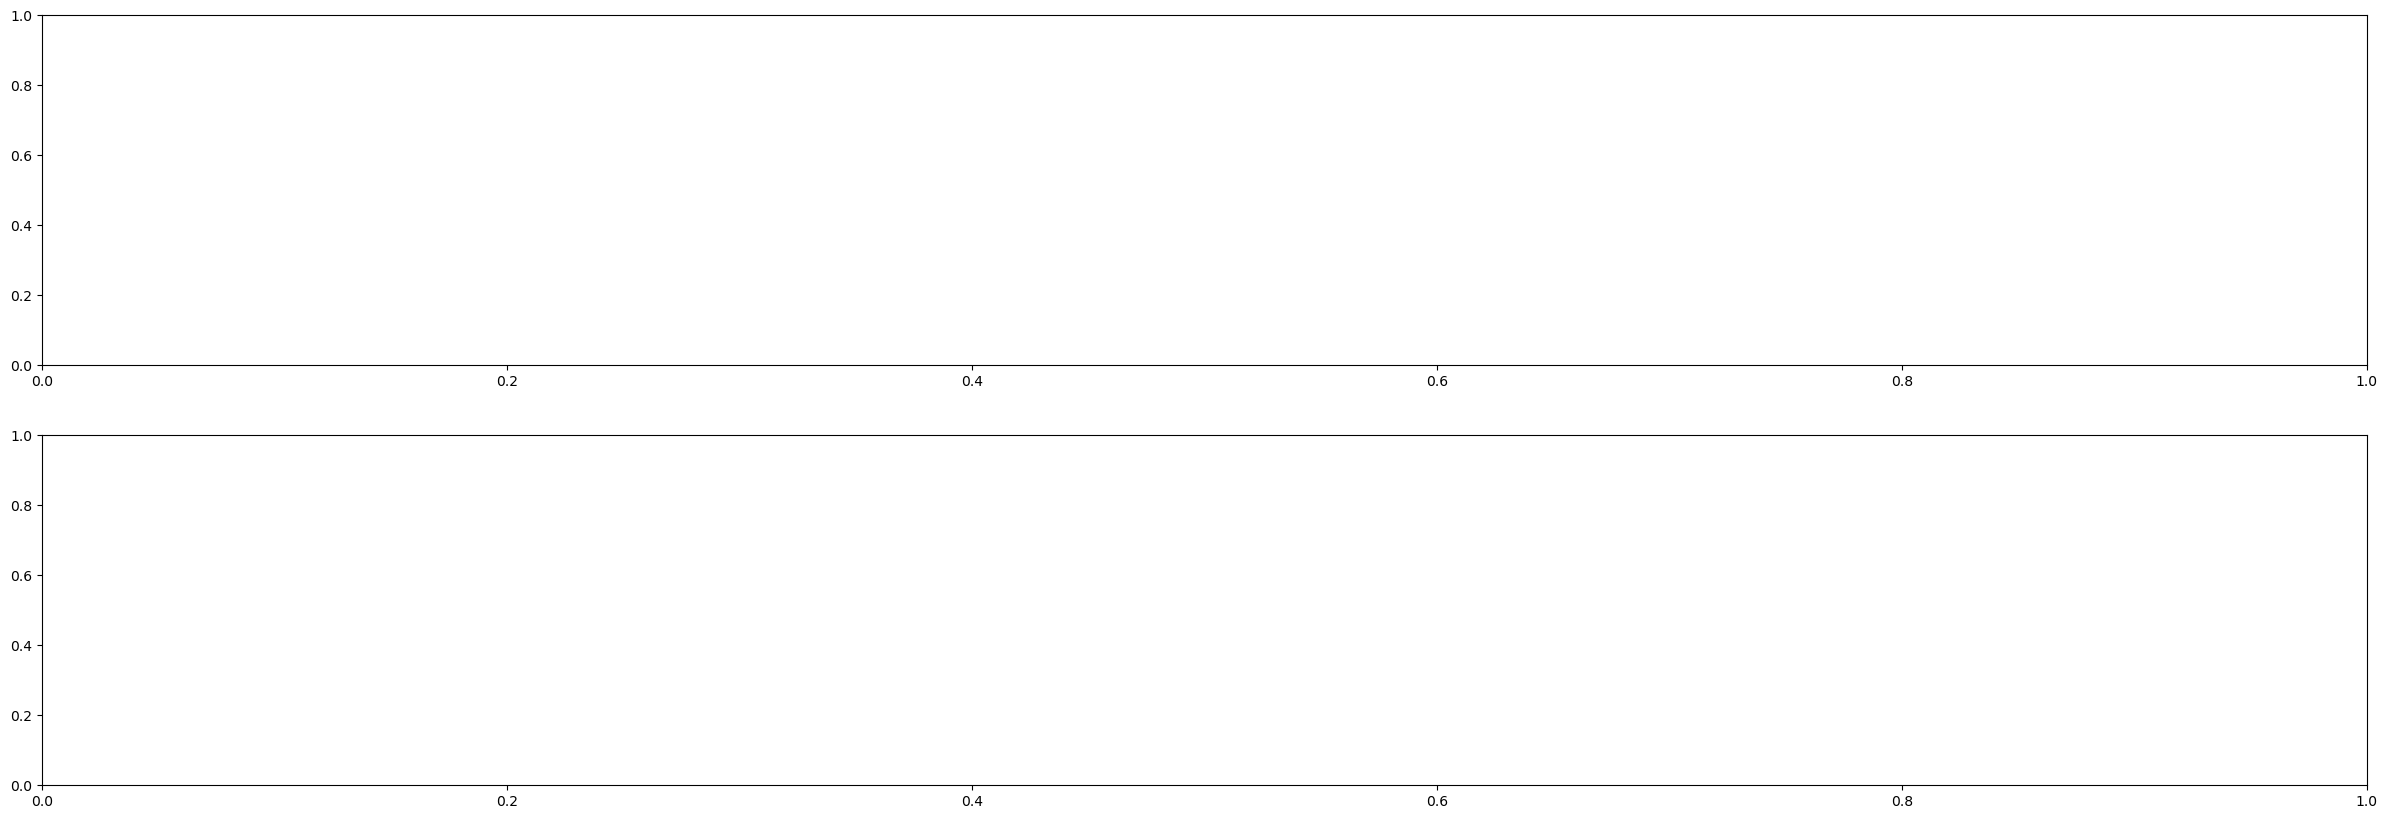

In [ ]:
k=100

for i in range(len(N1)):
    for j in range(len(n_ratios)):
        N = N1[i]
        n_ratio = n_ratios[j]

        _, inter_number = intersection_density(n_ratio, N, M)


        fig, axs = plt.subplots(2,1)
        fig.set_figwidth(30)
        fig.set_figheight(10)
        x = np.arange(N+1)
        axs[0].bar(x,prob_array[i][j])
        axs[0].set_title(f"Null path intersection probabilities, N = {N}, n_ratio = {n_ratio}")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("Probability of intersection with null")
        
        axs[1].hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
        axs[1].set_title(f"Total number of null path intersections, N = {N}, n_ratio = {n_ratio}")
        axs[1].set_xlabel("number of intersections with null")
        axs[1].set_ylabel("density")
        
        Np = int(N / (n_ratio + 1))

        d = np.gcd(N, Np)
        # print(d)
        # print(N/n_ratio)
        # print(N / (N/d - 1))
        
        if int(N / (N/d - 1)) >= 2:
            axs[1].plot(np.arange(k+1), intersect_num_dp(int(N / (N/d - 1) / 2 + n_ratio)*2, k))
        plt.show()

        del inter_number
        gc.collect()
        cp._default_memory_pool.free_all_blocks()

[8 4 3 ... 2 4 6]


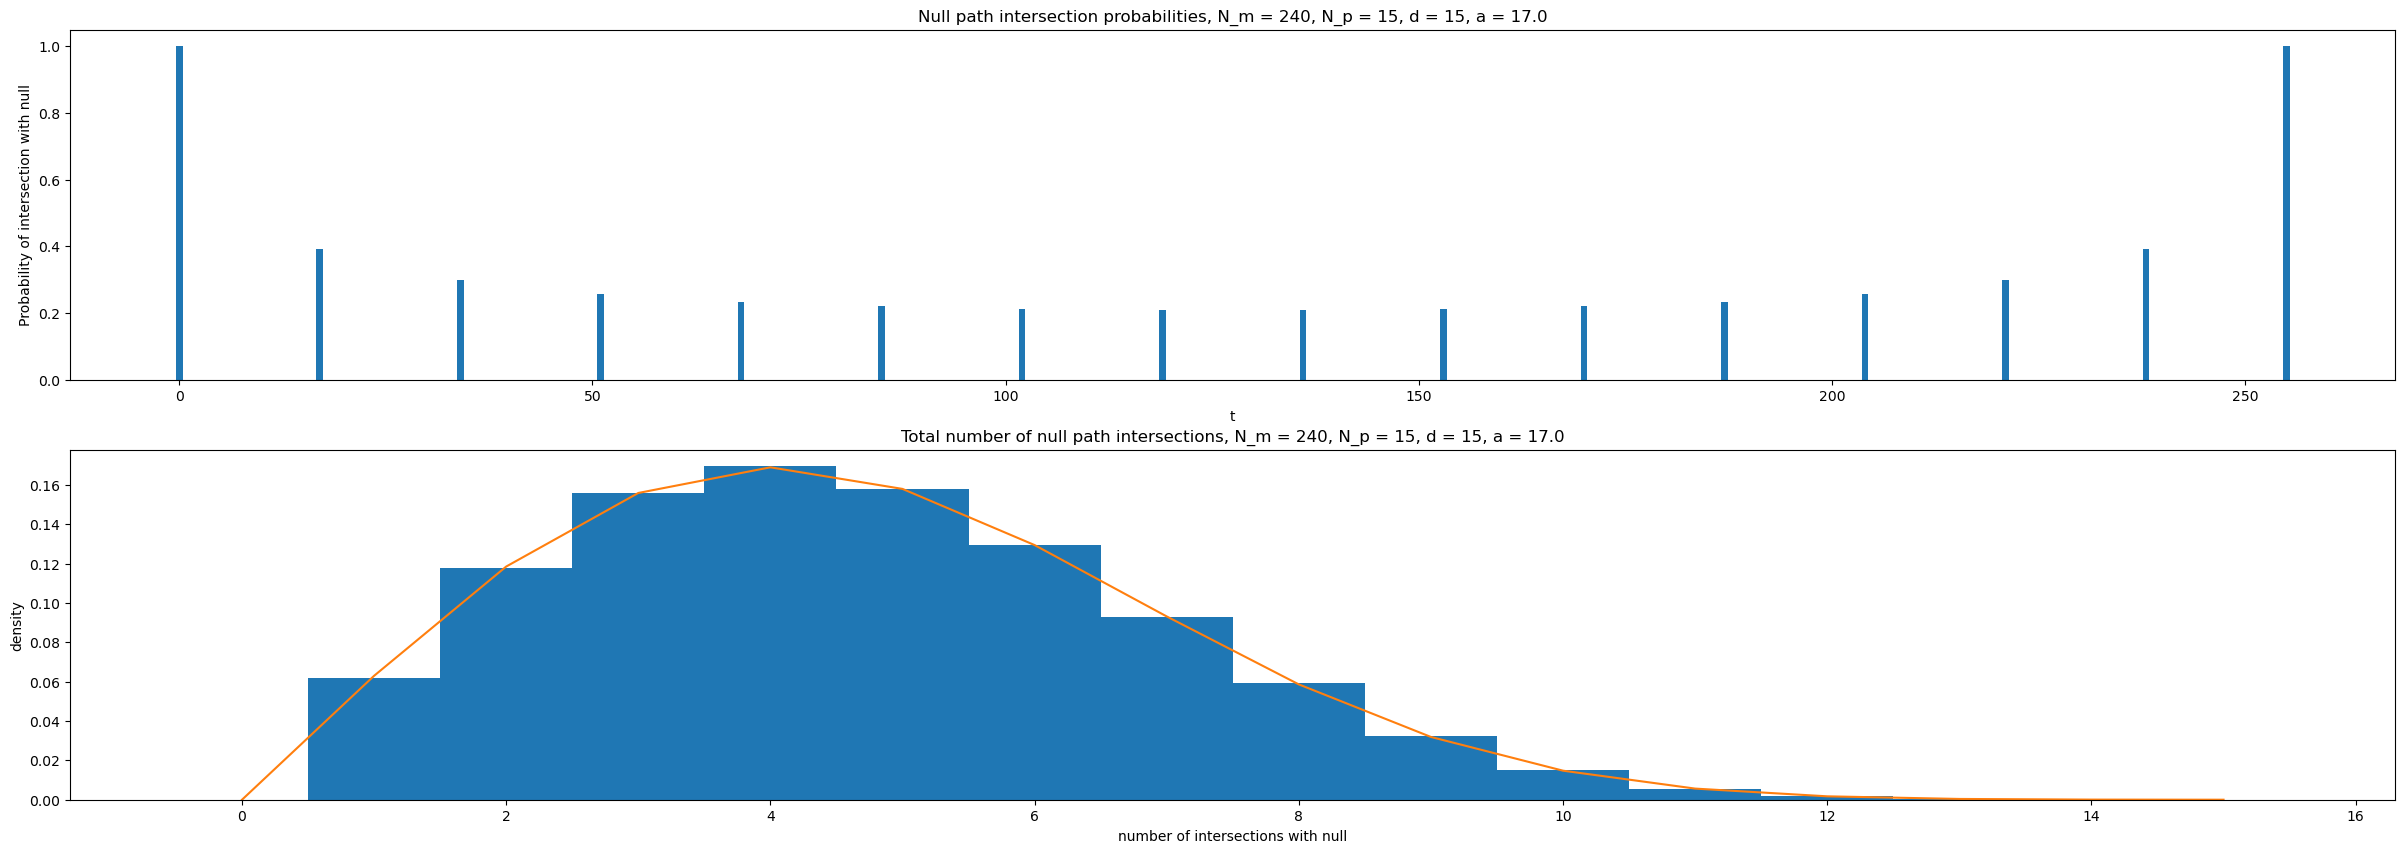

[12 18  4 ... 34  1  1]


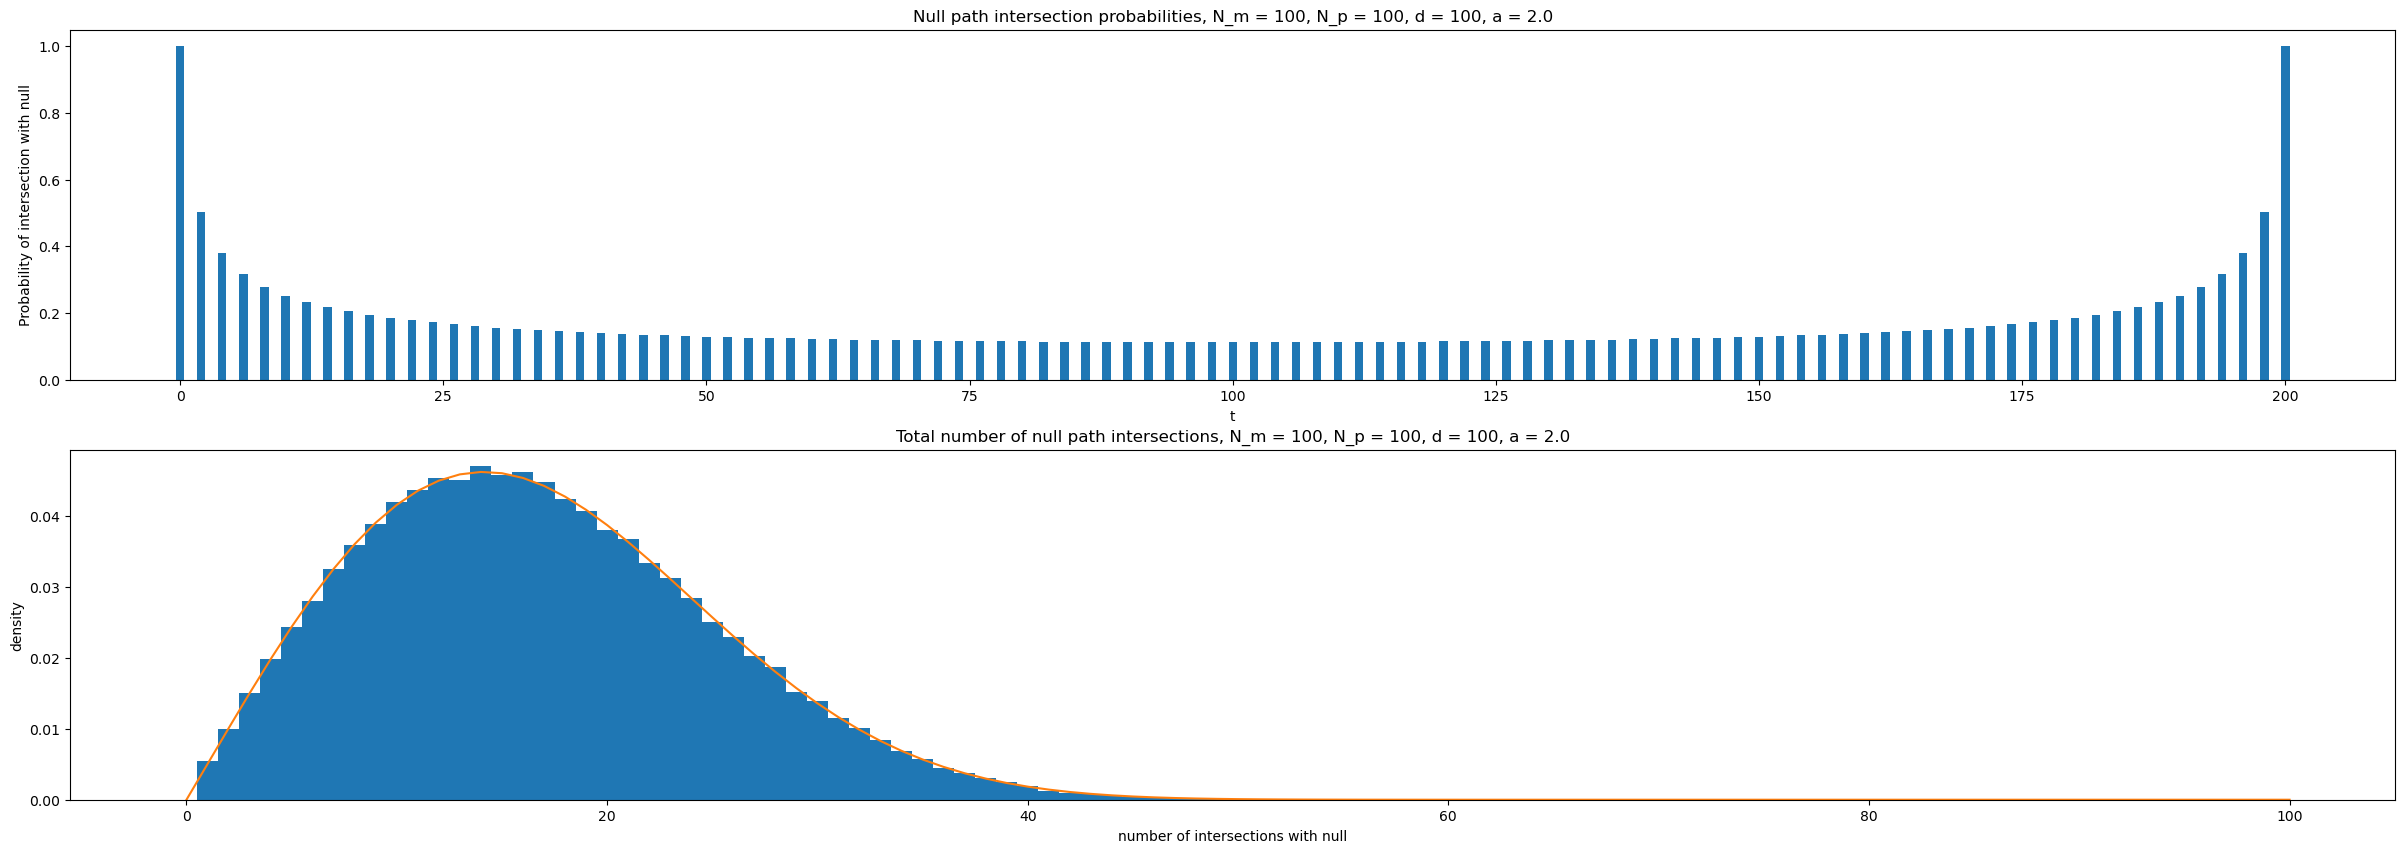

[ 2 13  8 ...  9  8  8]


KeyboardInterrupt: 

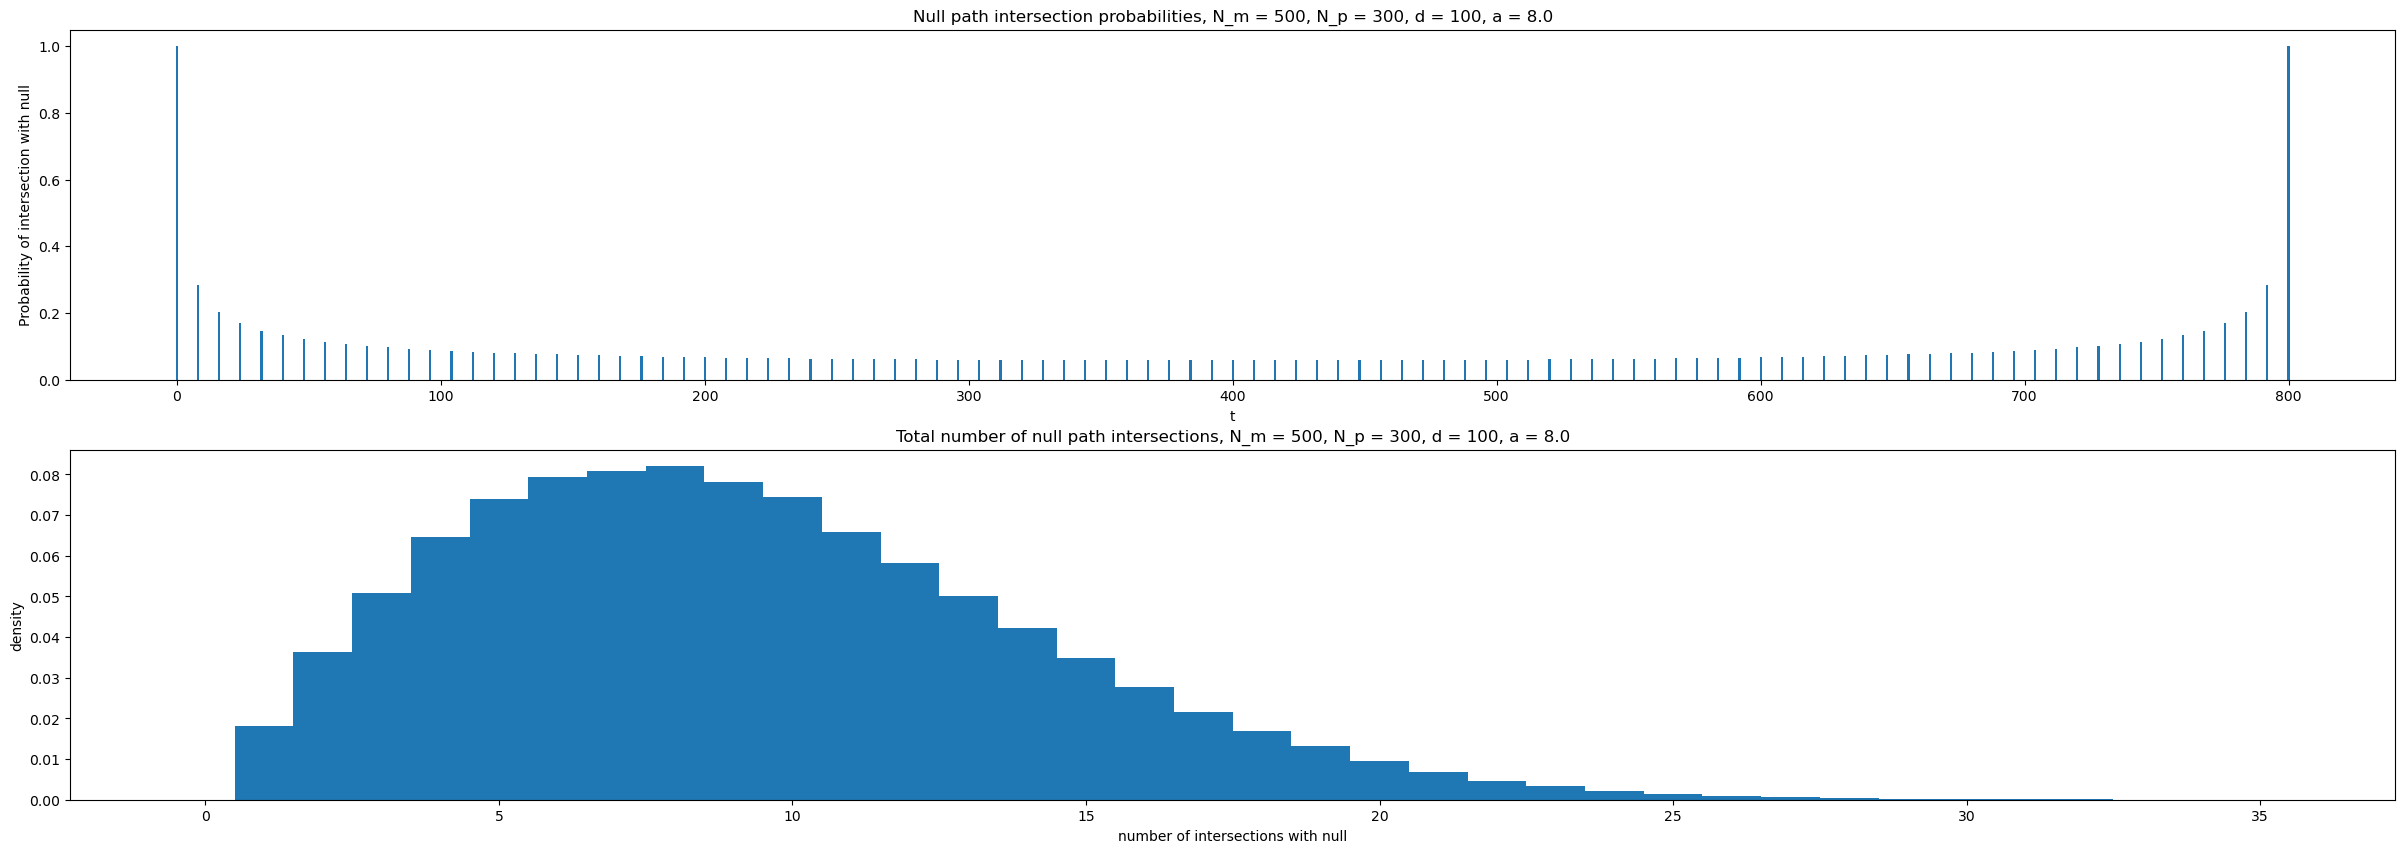

In [40]:
# Exact intersection probabilities 
# n_ratios = [15] + [i for i in range(1,4)]
# N1 = [15 * 16] + [i * 300 for i in range(1,3)]

N_ps = [15, 100, 300, 400, 200]
N_ms = [15 * 16, 100, 500, 500, 500]
k=70

M = 200000

for i in range(len(N_ps)):
    N_p = N_ps[i]
    N_m = N_ms[i]
    N = N_p + N_m

    d = np.gcd(N, N_p)
    a = N / d
    b = N_p / d


    _, inter_number = intersection_density(N_m, N_p, M)
    print(inter_number)
    
    fig, axs = plt.subplots(2,1)
    fig.set_figwidth(30)
    fig.set_figheight(10)
    x = np.arange(N+1)
    axs[0].bar(x,null_intersection_exact(N_m, N_p))
    axs[0].set_title(f"Null path intersection probabilities, N_m = {N_m}, N_p = {N_p}, d = {d}, a = {a}")
    axs[0].set_xlabel("t")
    axs[0].set_ylabel("Probability of intersection with null")
    
    axs[1].hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
    axs[1].set_title(f"Total number of null path intersections, N_m = {N_m}, N_p = {N_p}, d = {d}, a = {a}")
    axs[1].set_xlabel("number of intersections with null")
    axs[1].set_ylabel("density")


    # print(d)
    # print(N/n_ratio)
    # print(N / (N/d - 1))
    
    if int(N / (N/d - 1)) >= 2:
        # axs[1].plot(np.arange(k+1), intersect_num_dp(int(N / (N/d - 1) / 2)*2, k))
        # axs[1].plot(np.arange(k+1) * 2 / a, intersect_num_dp(N_m * 2, k) * a / 2)
        axs[1].plot(intersect_num_dp(N_m, N_p, K = 60))

    plt.show()

    del inter_number
    gc.collect()
    cp._default_memory_pool.free_all_blocks()

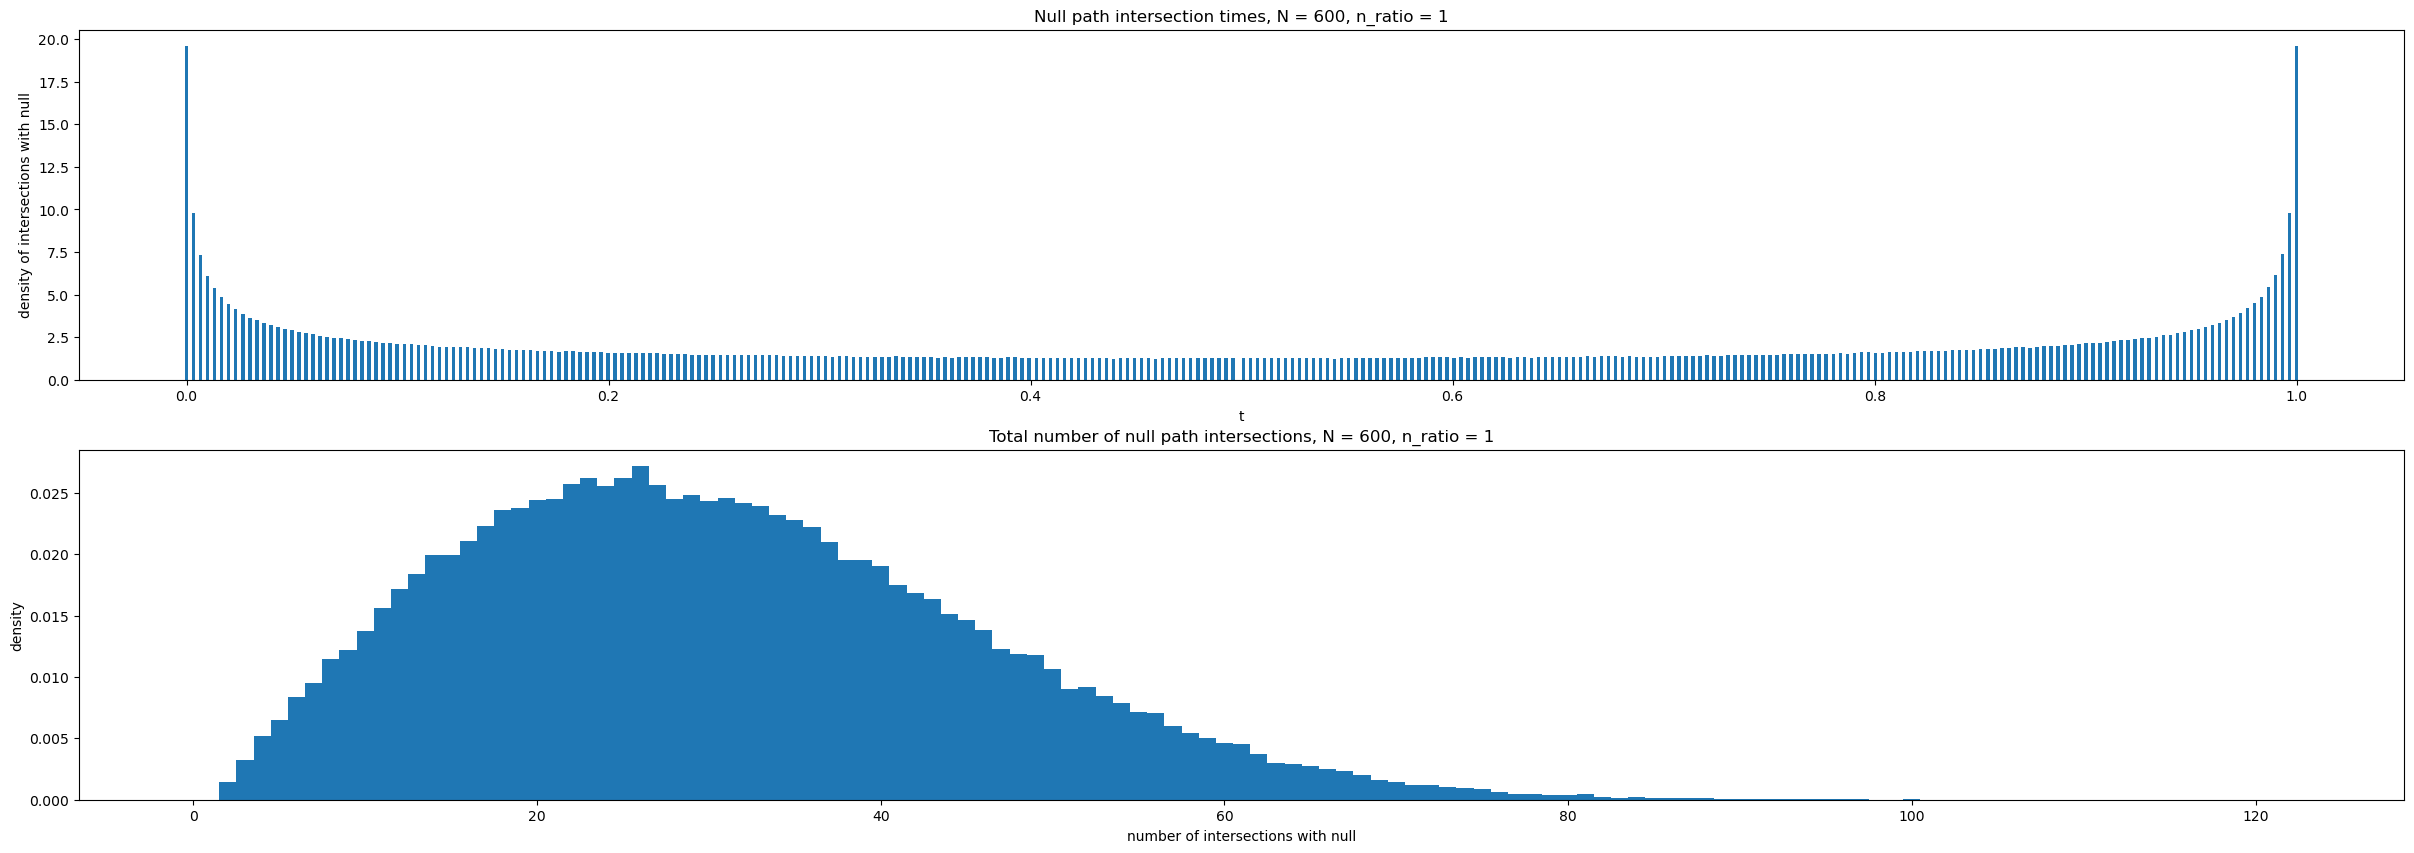

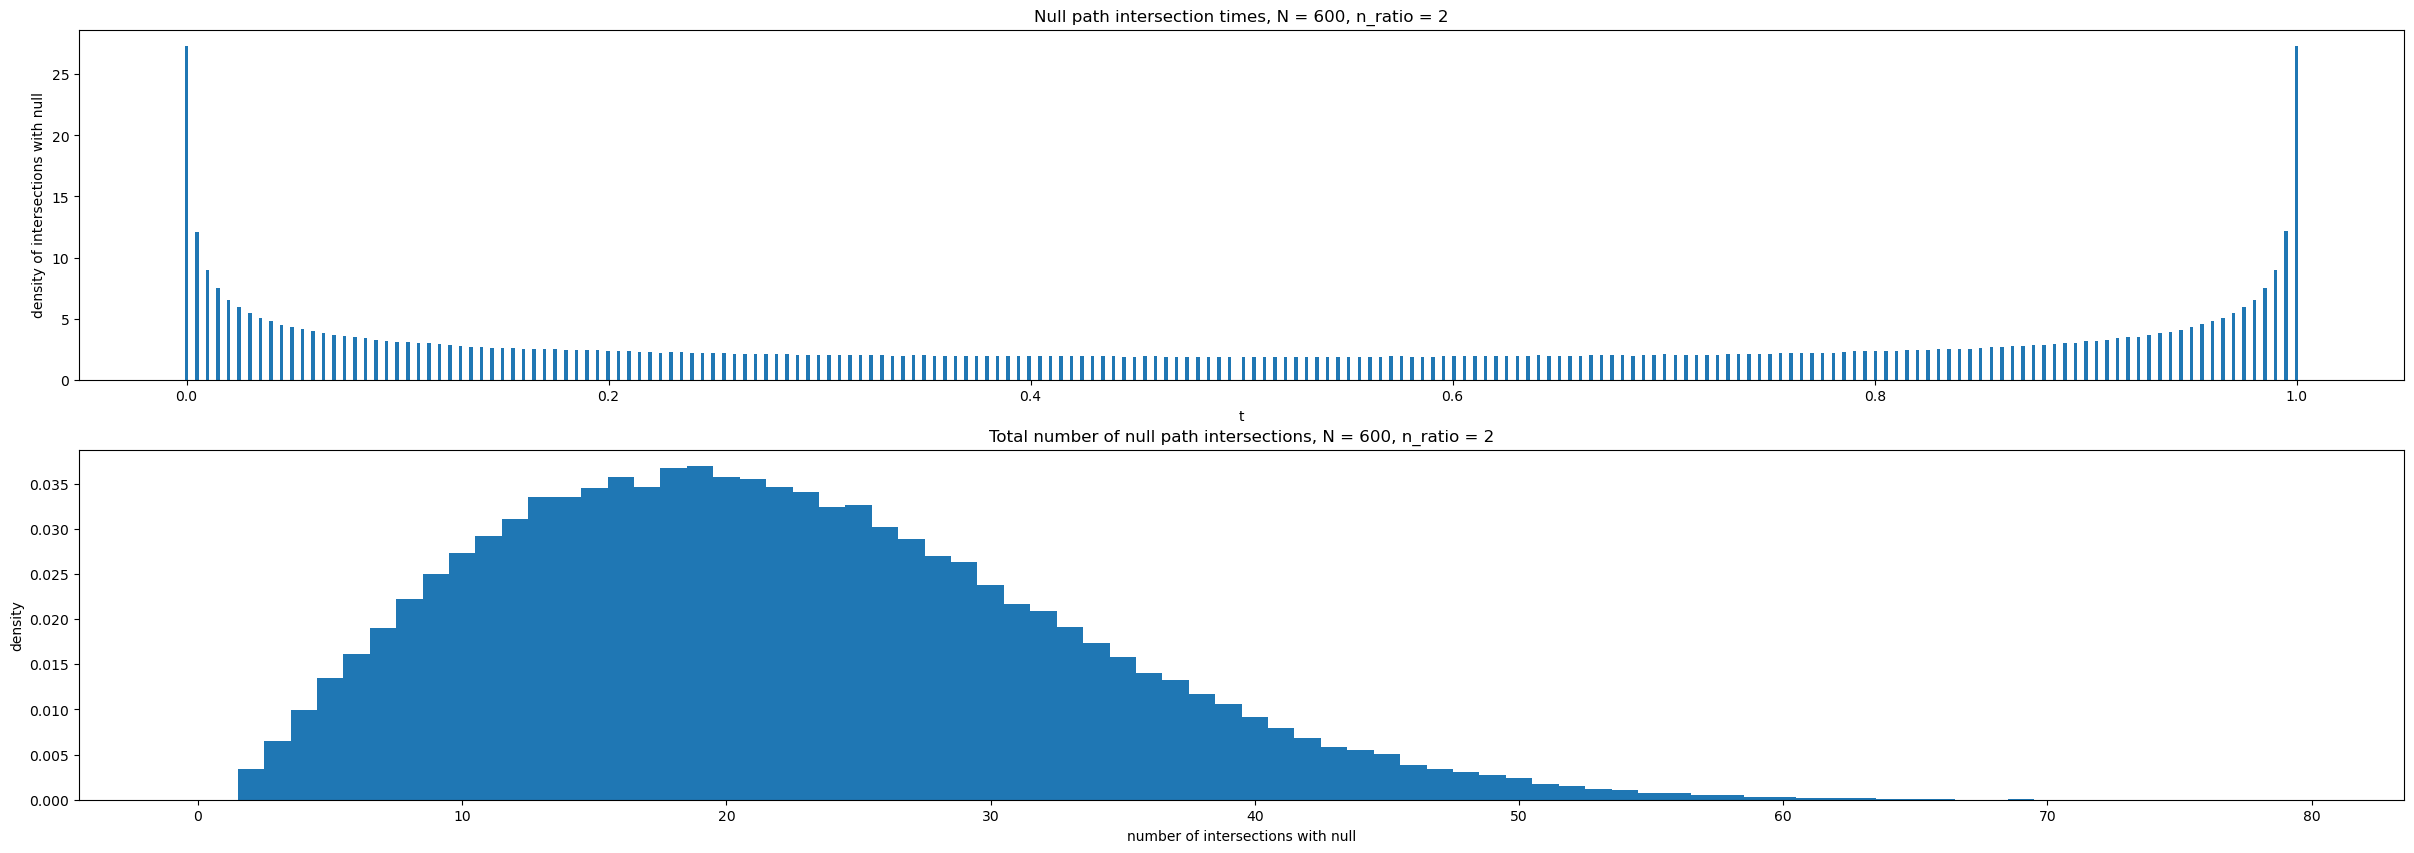

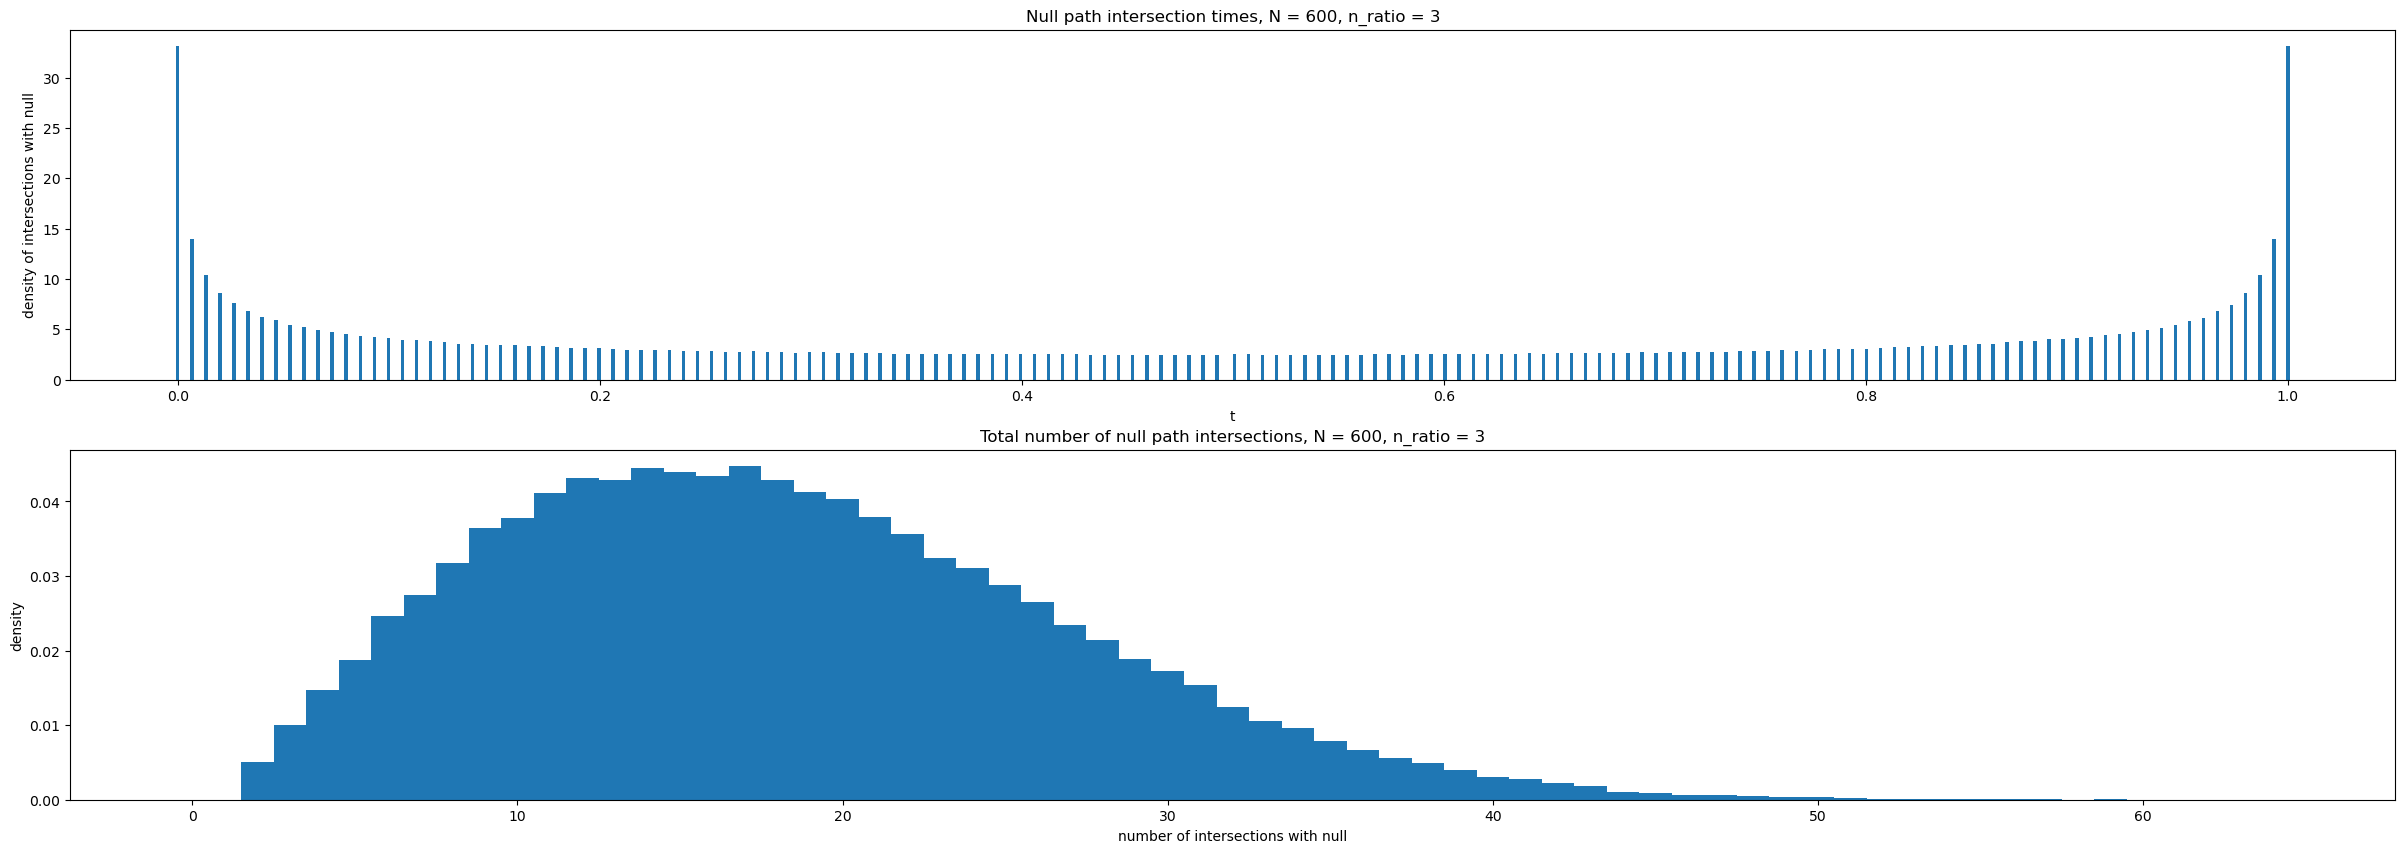

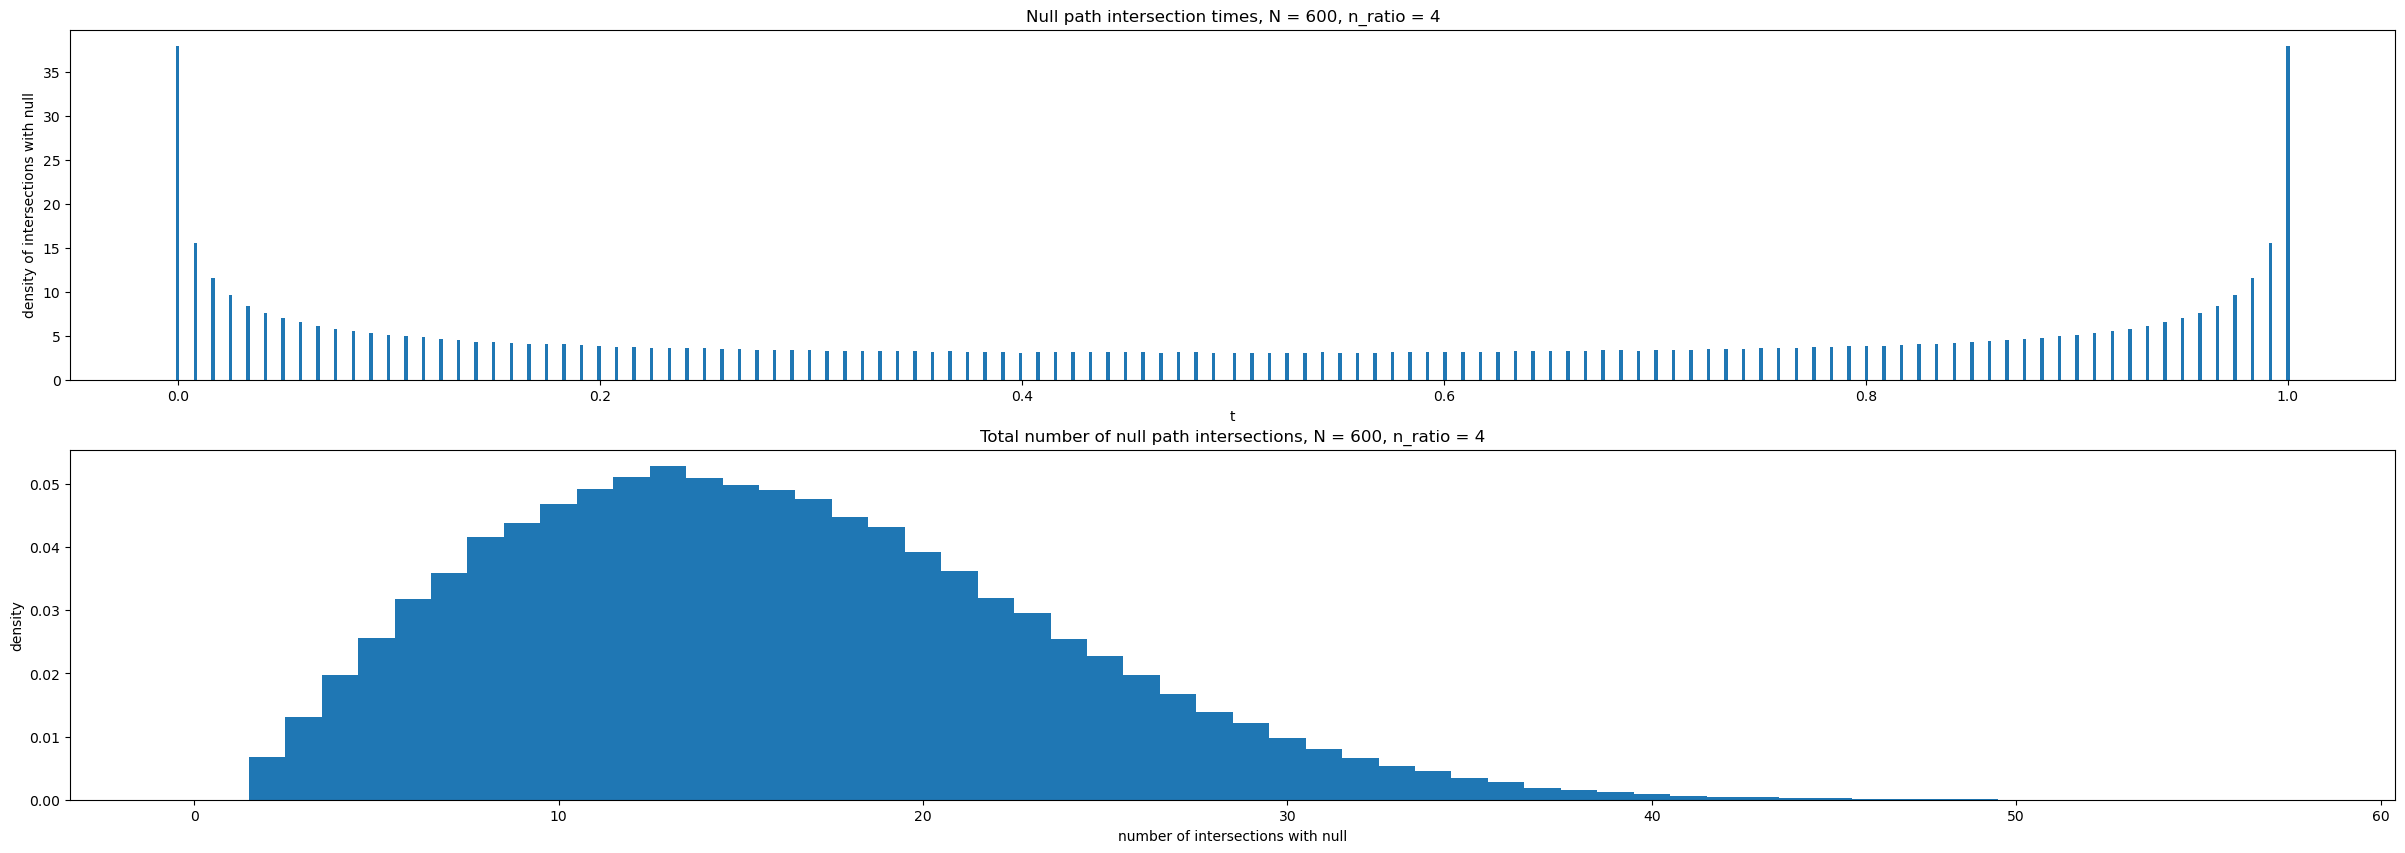

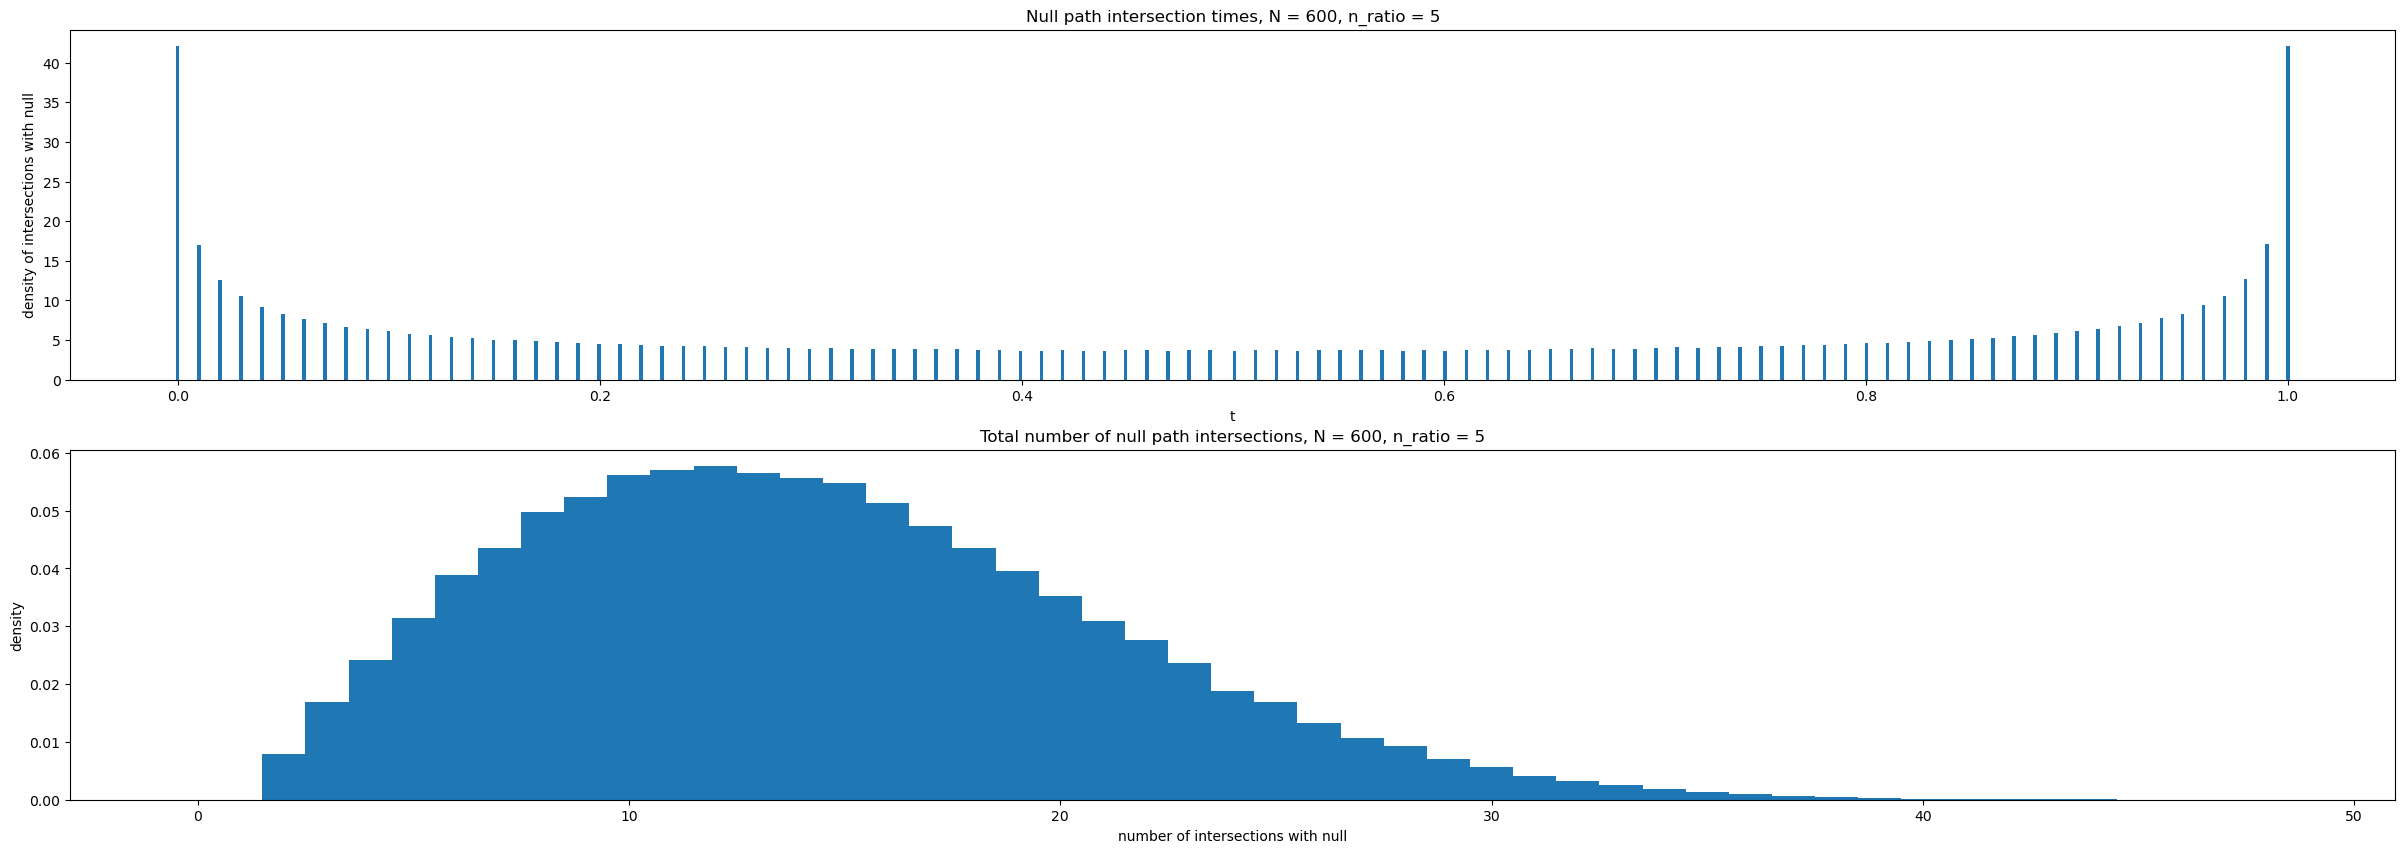

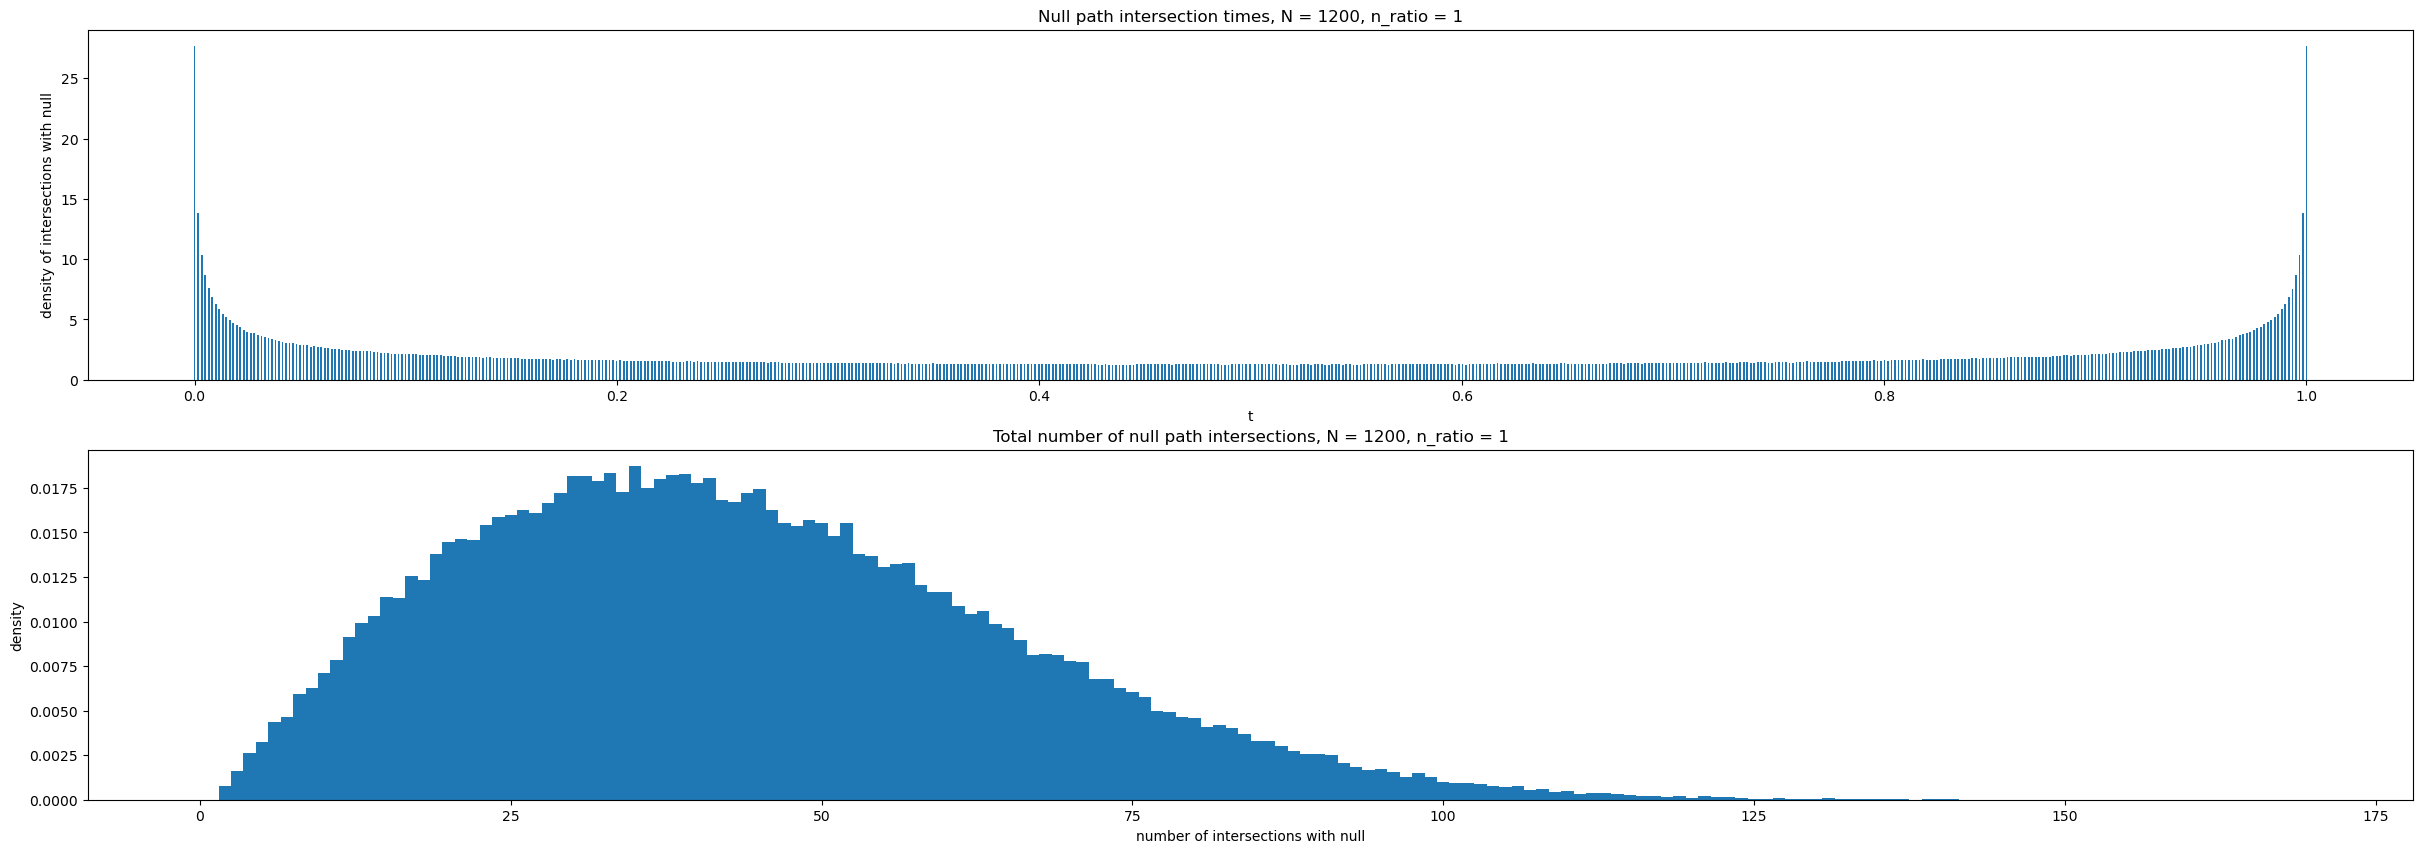

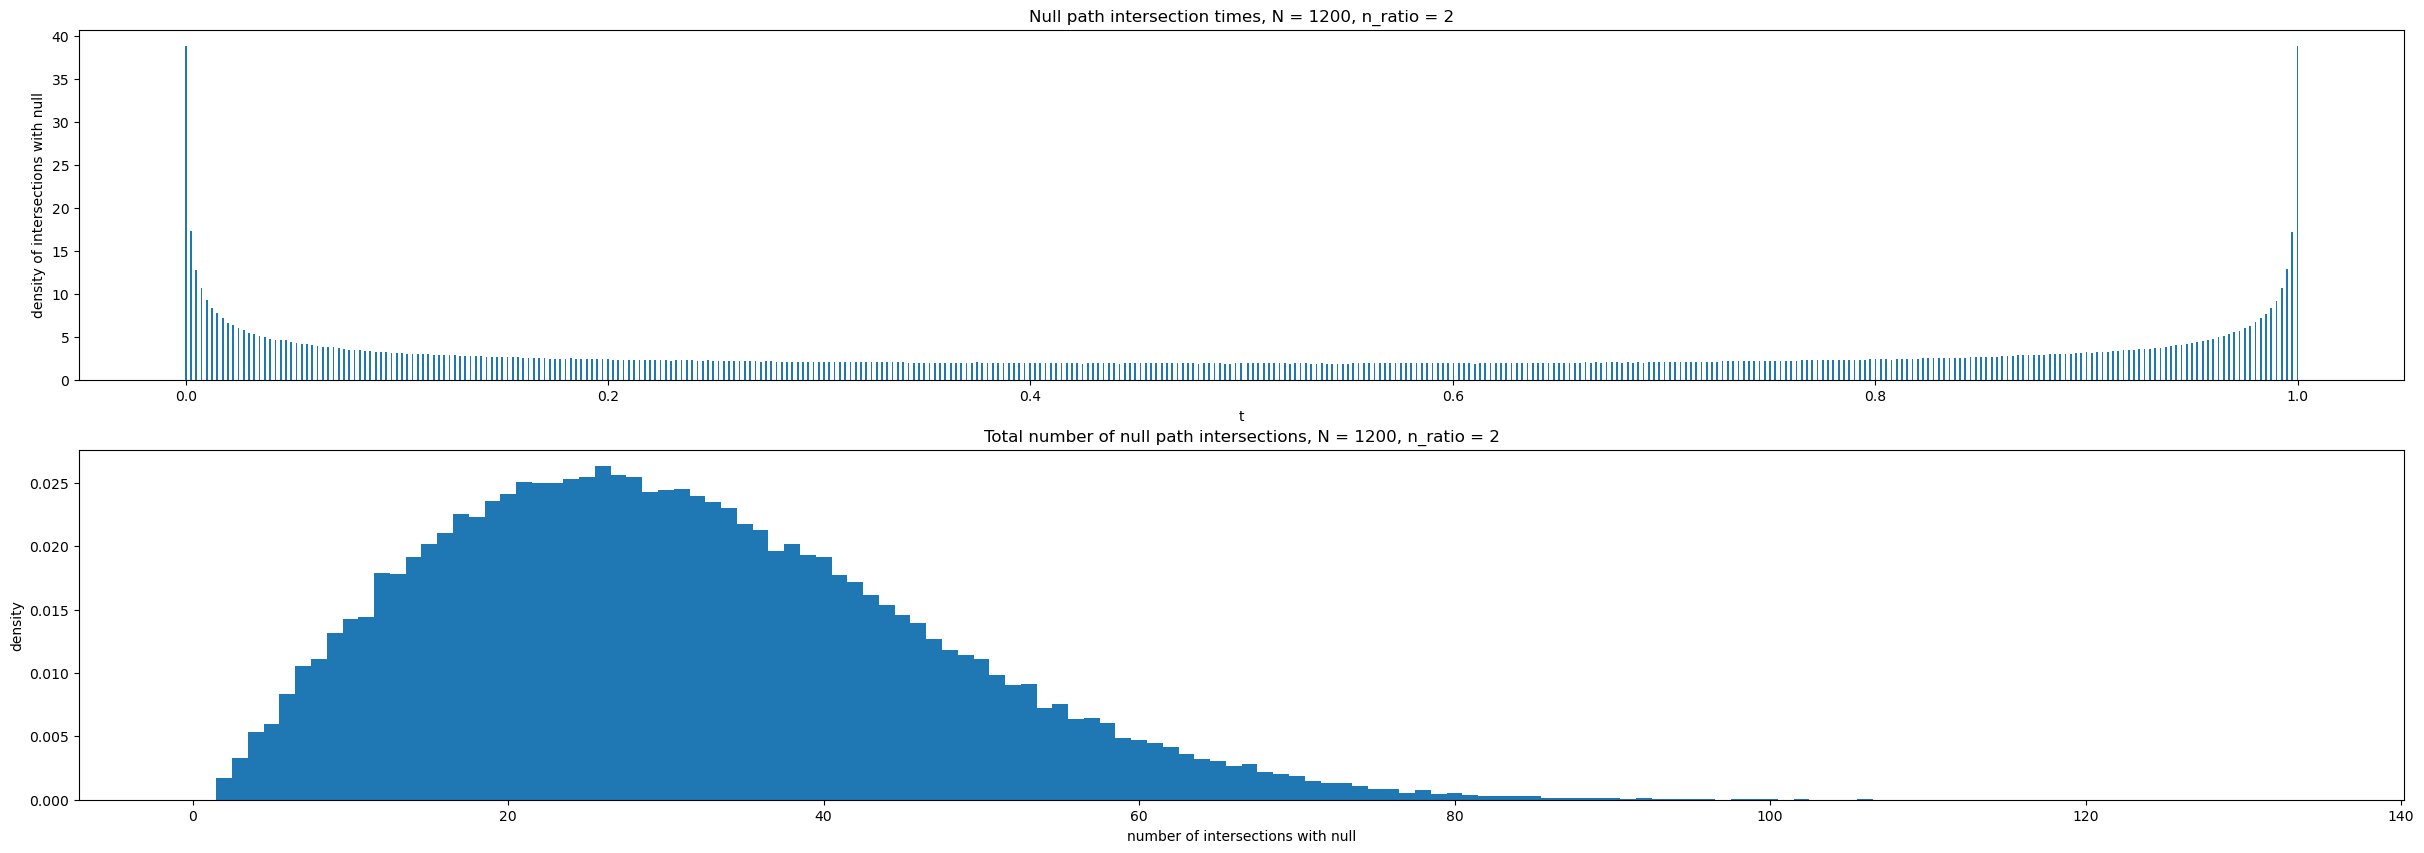

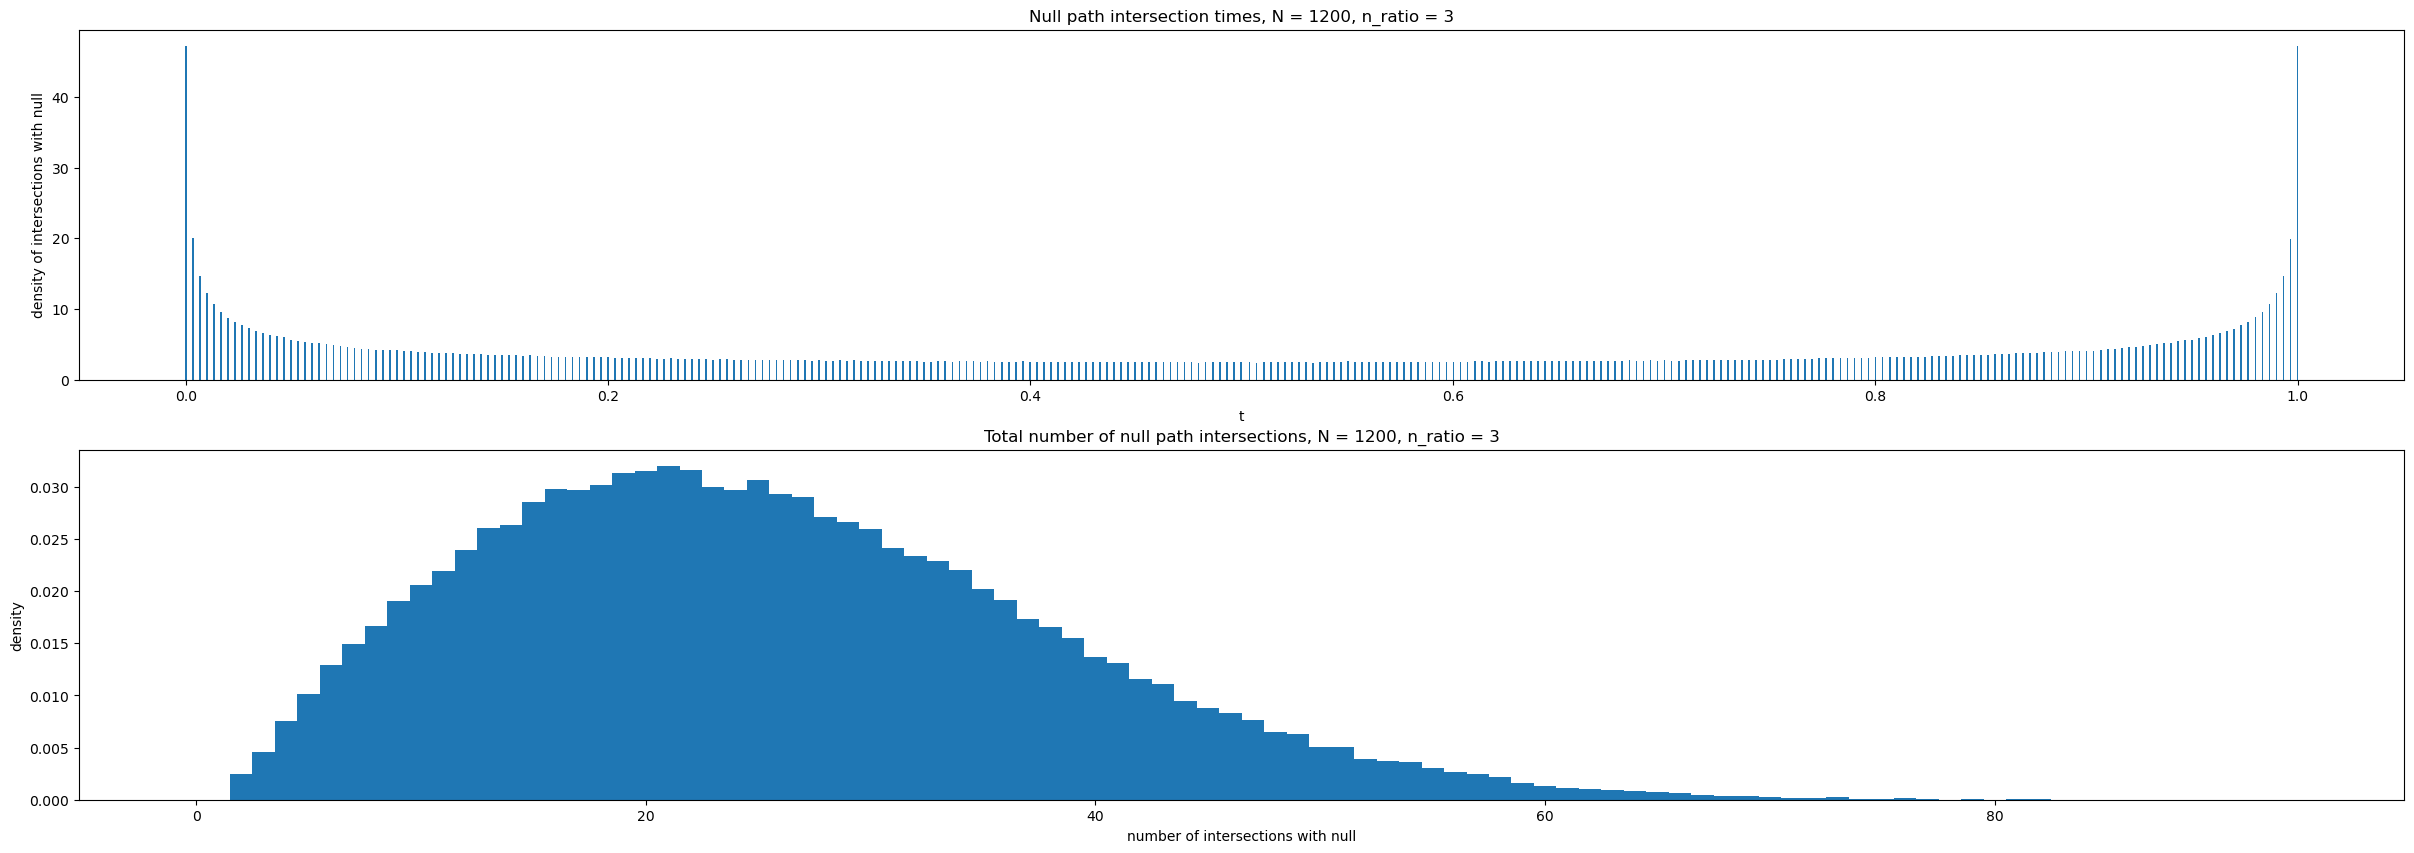

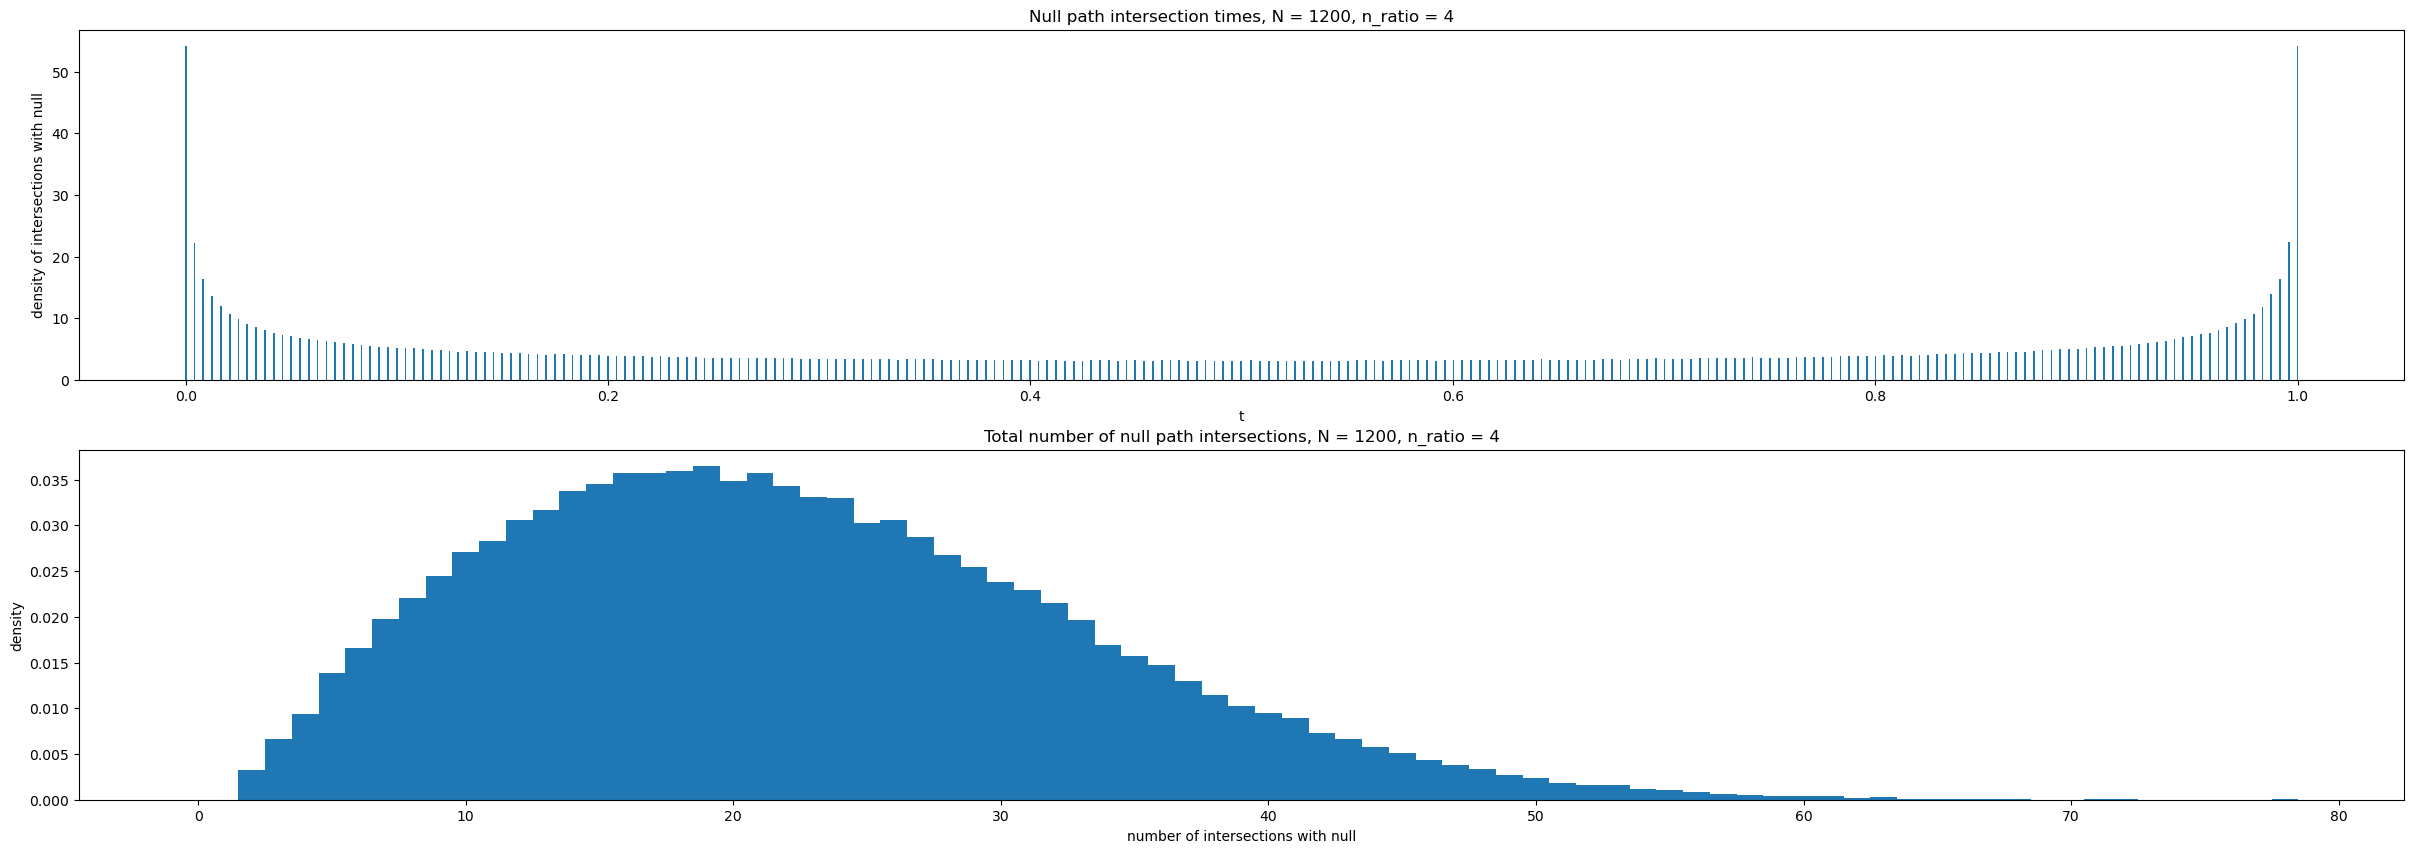

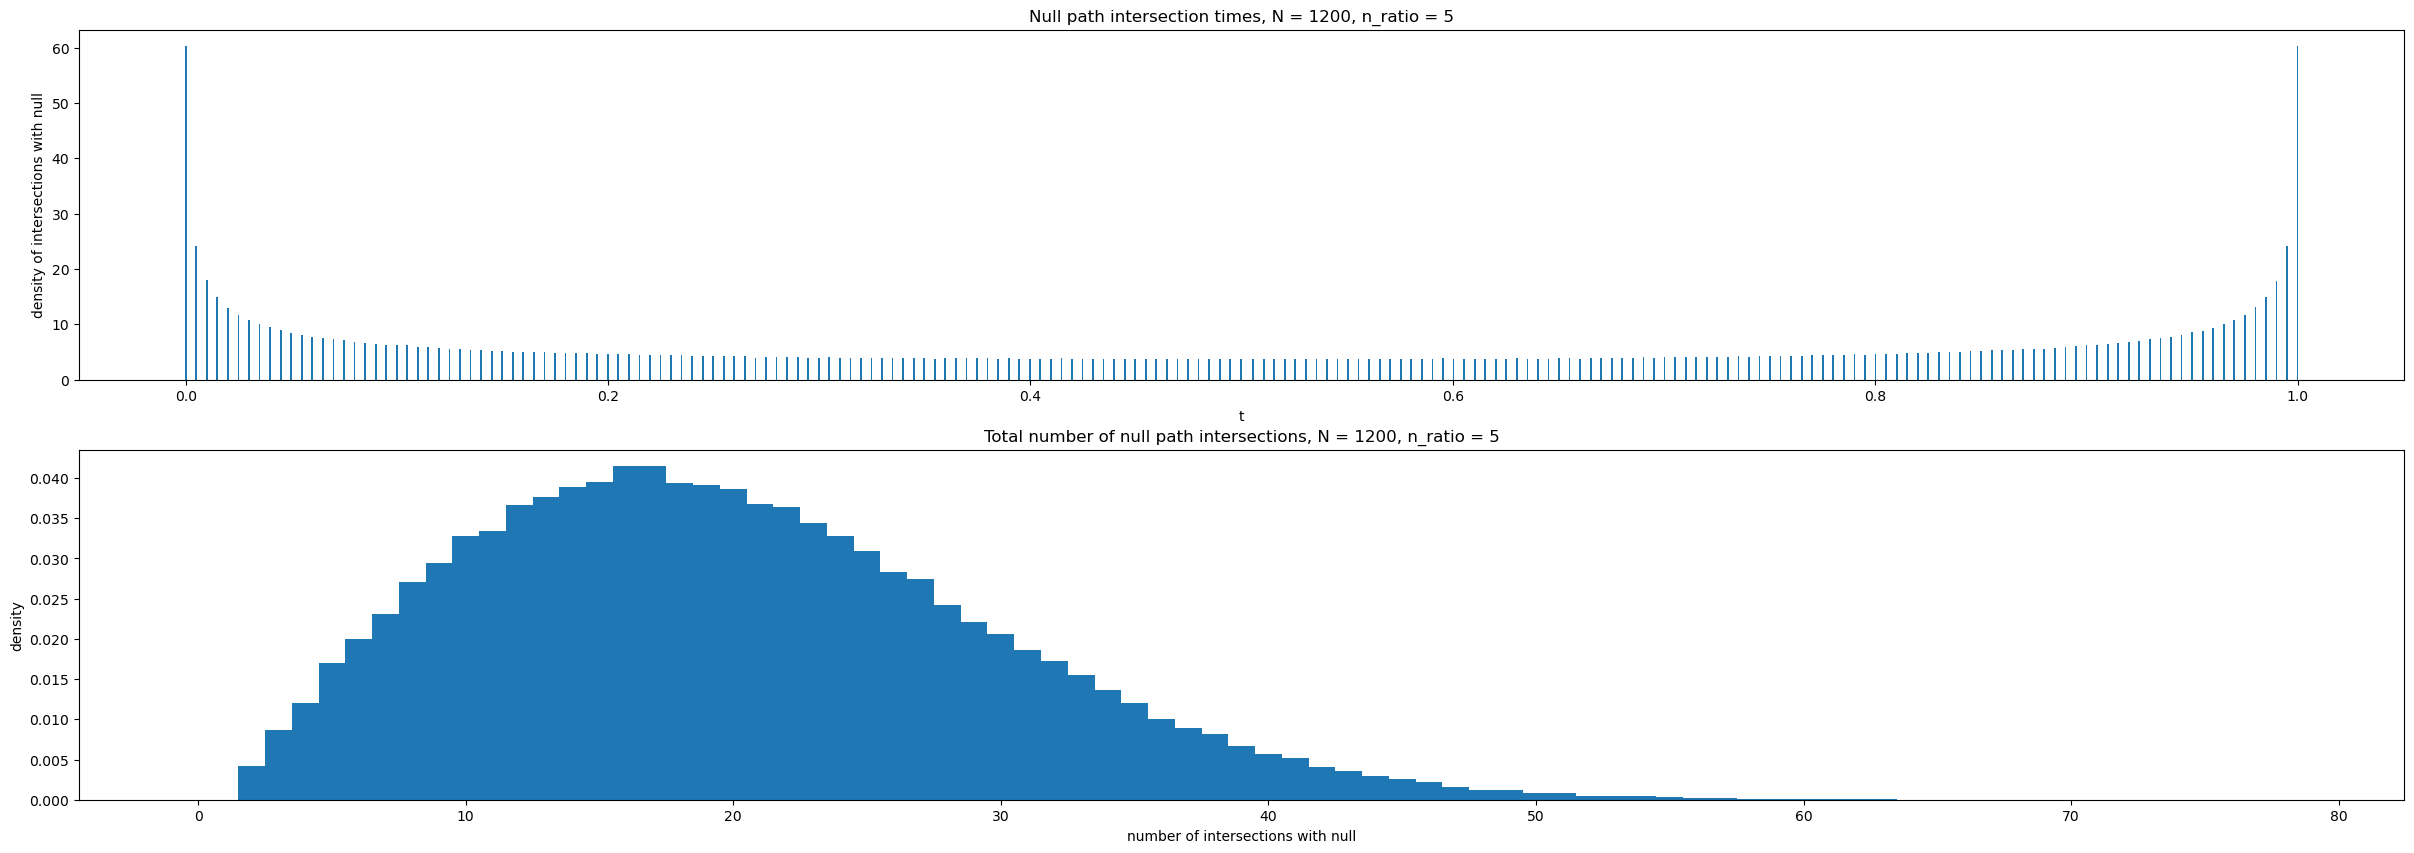

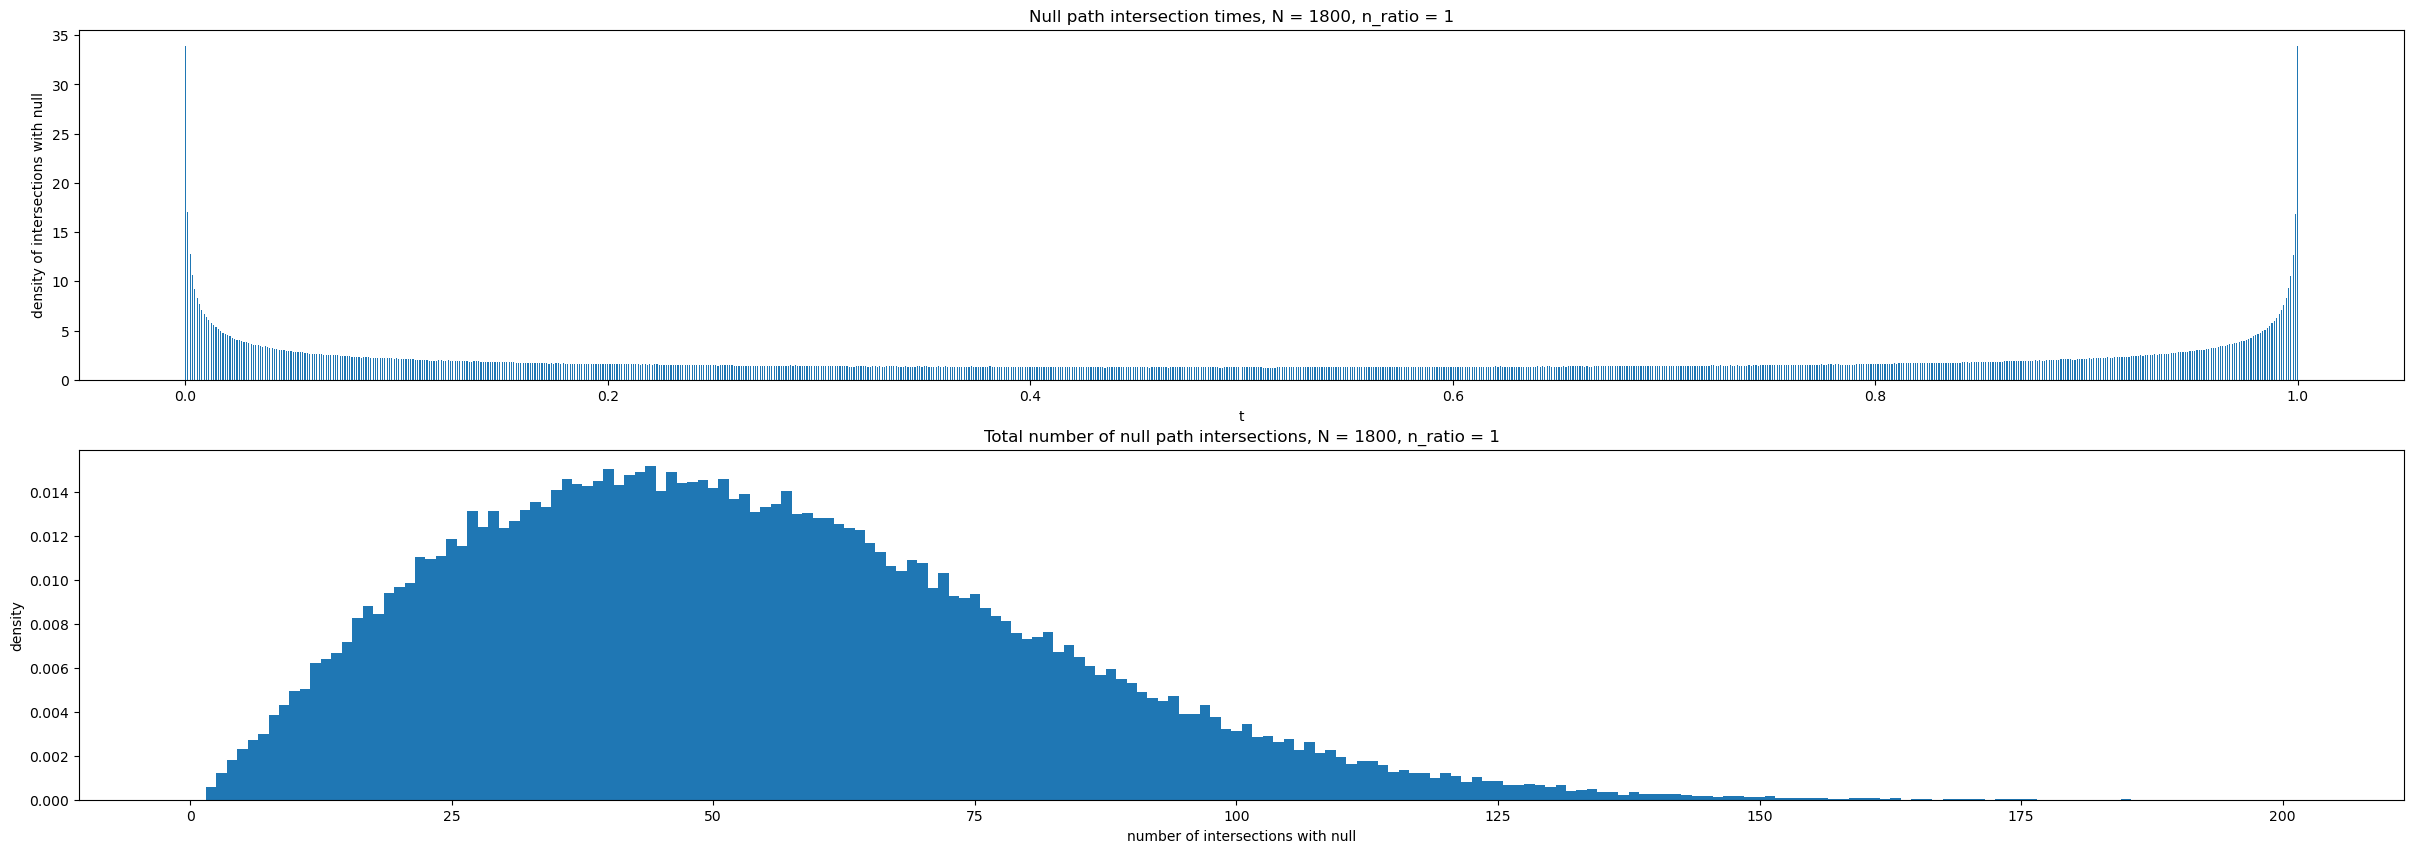

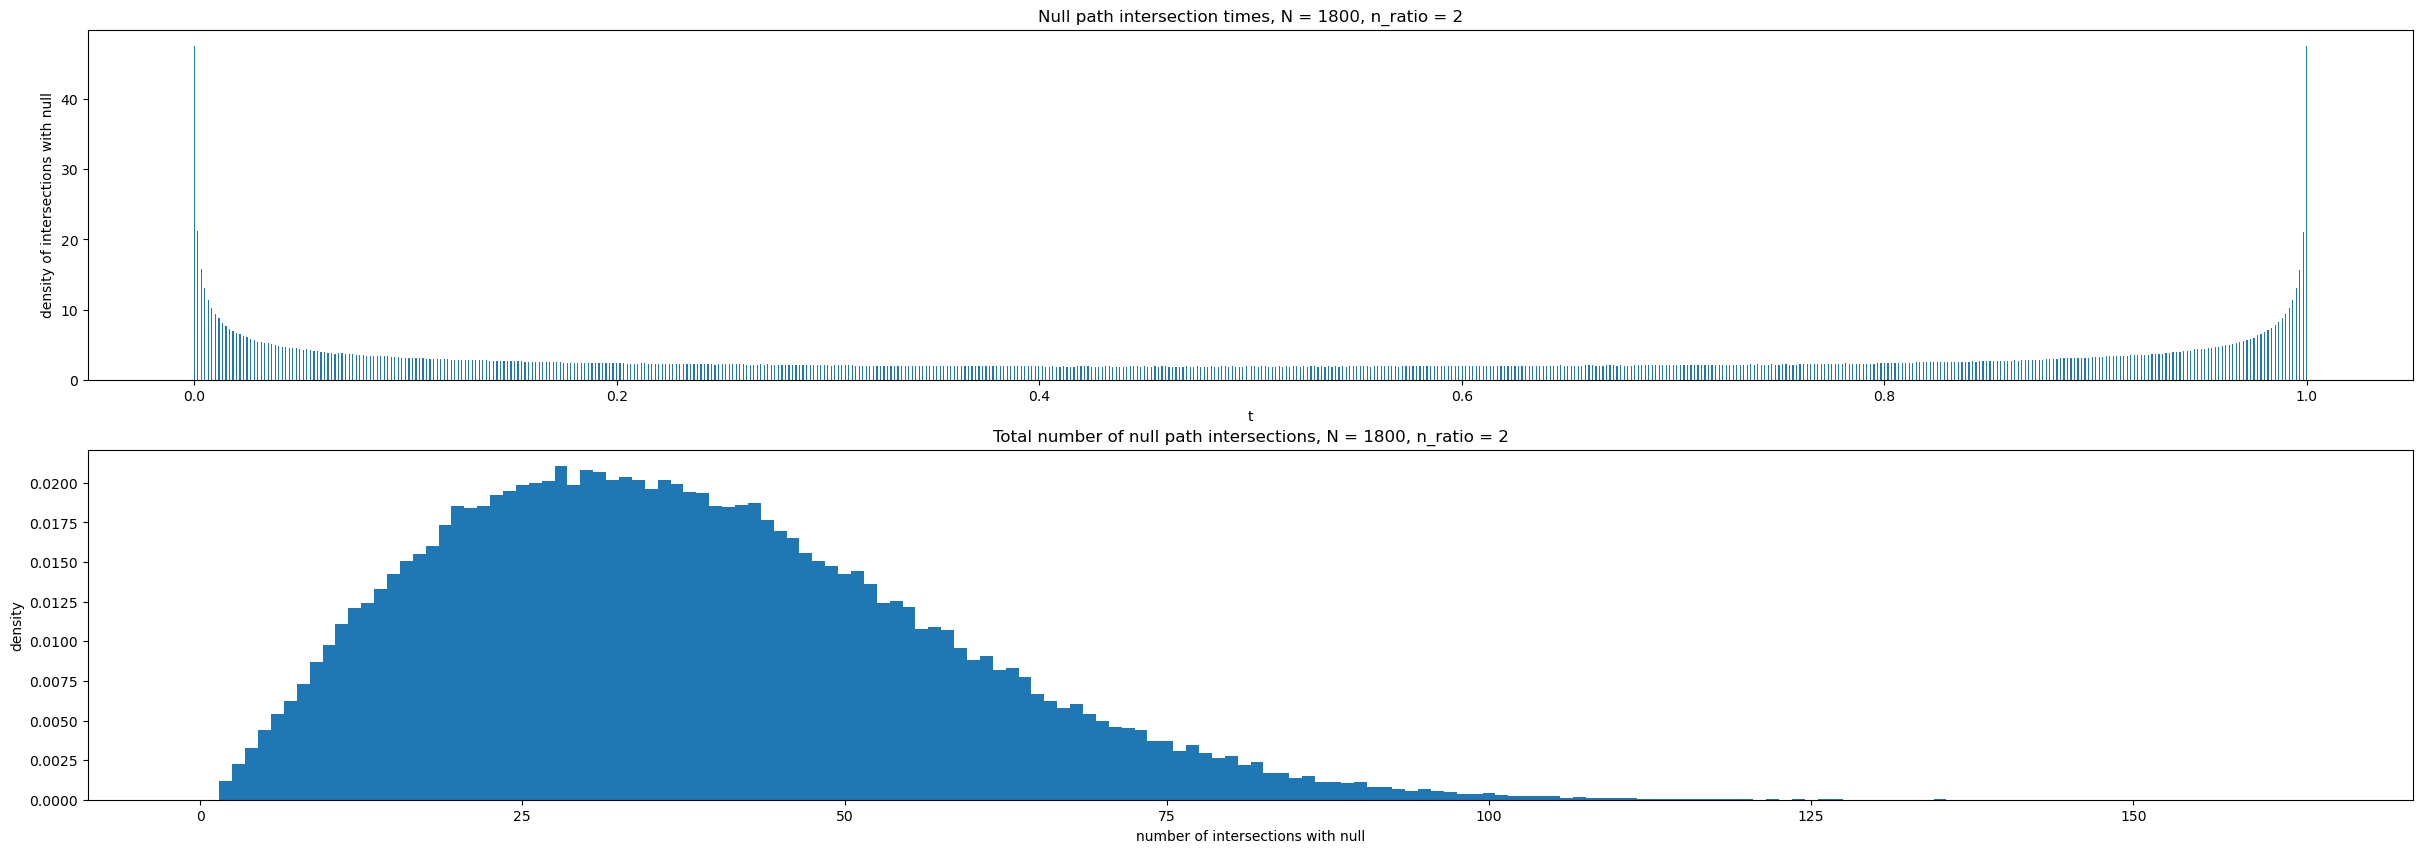

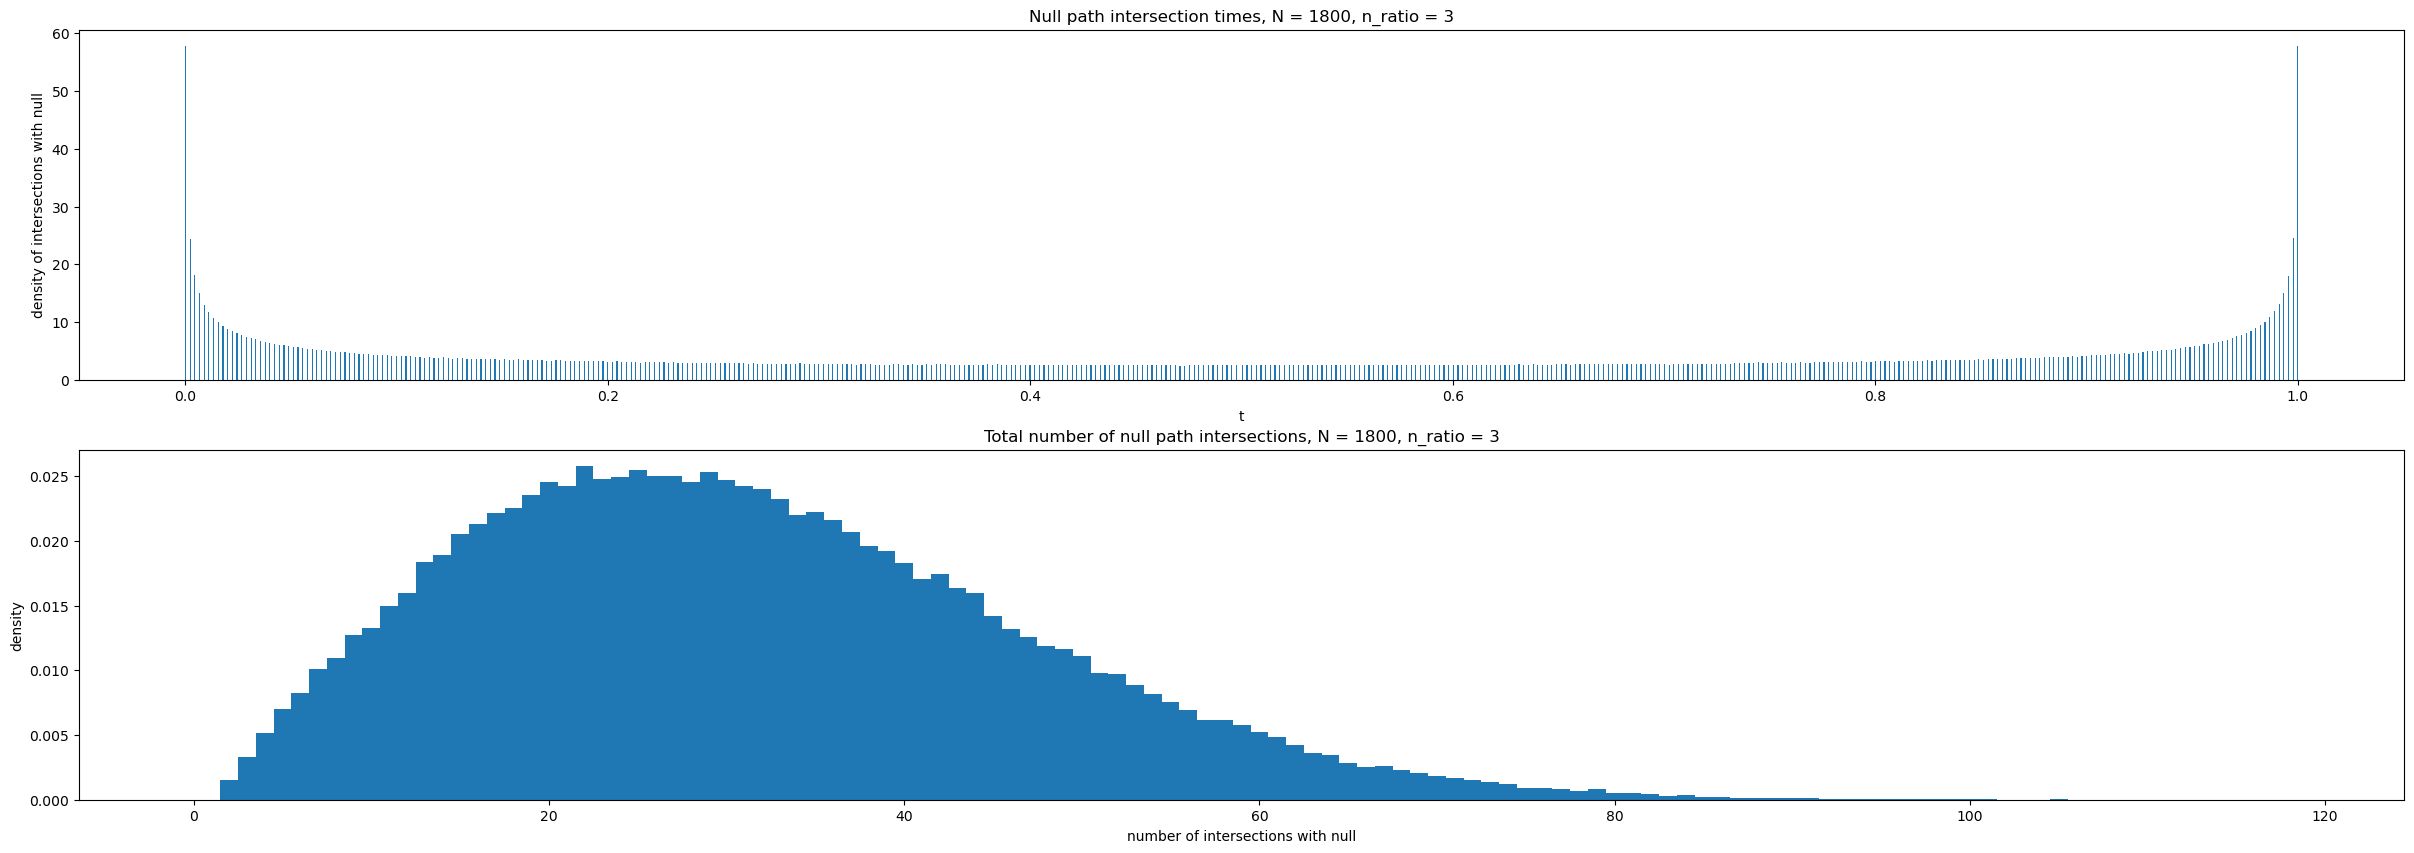

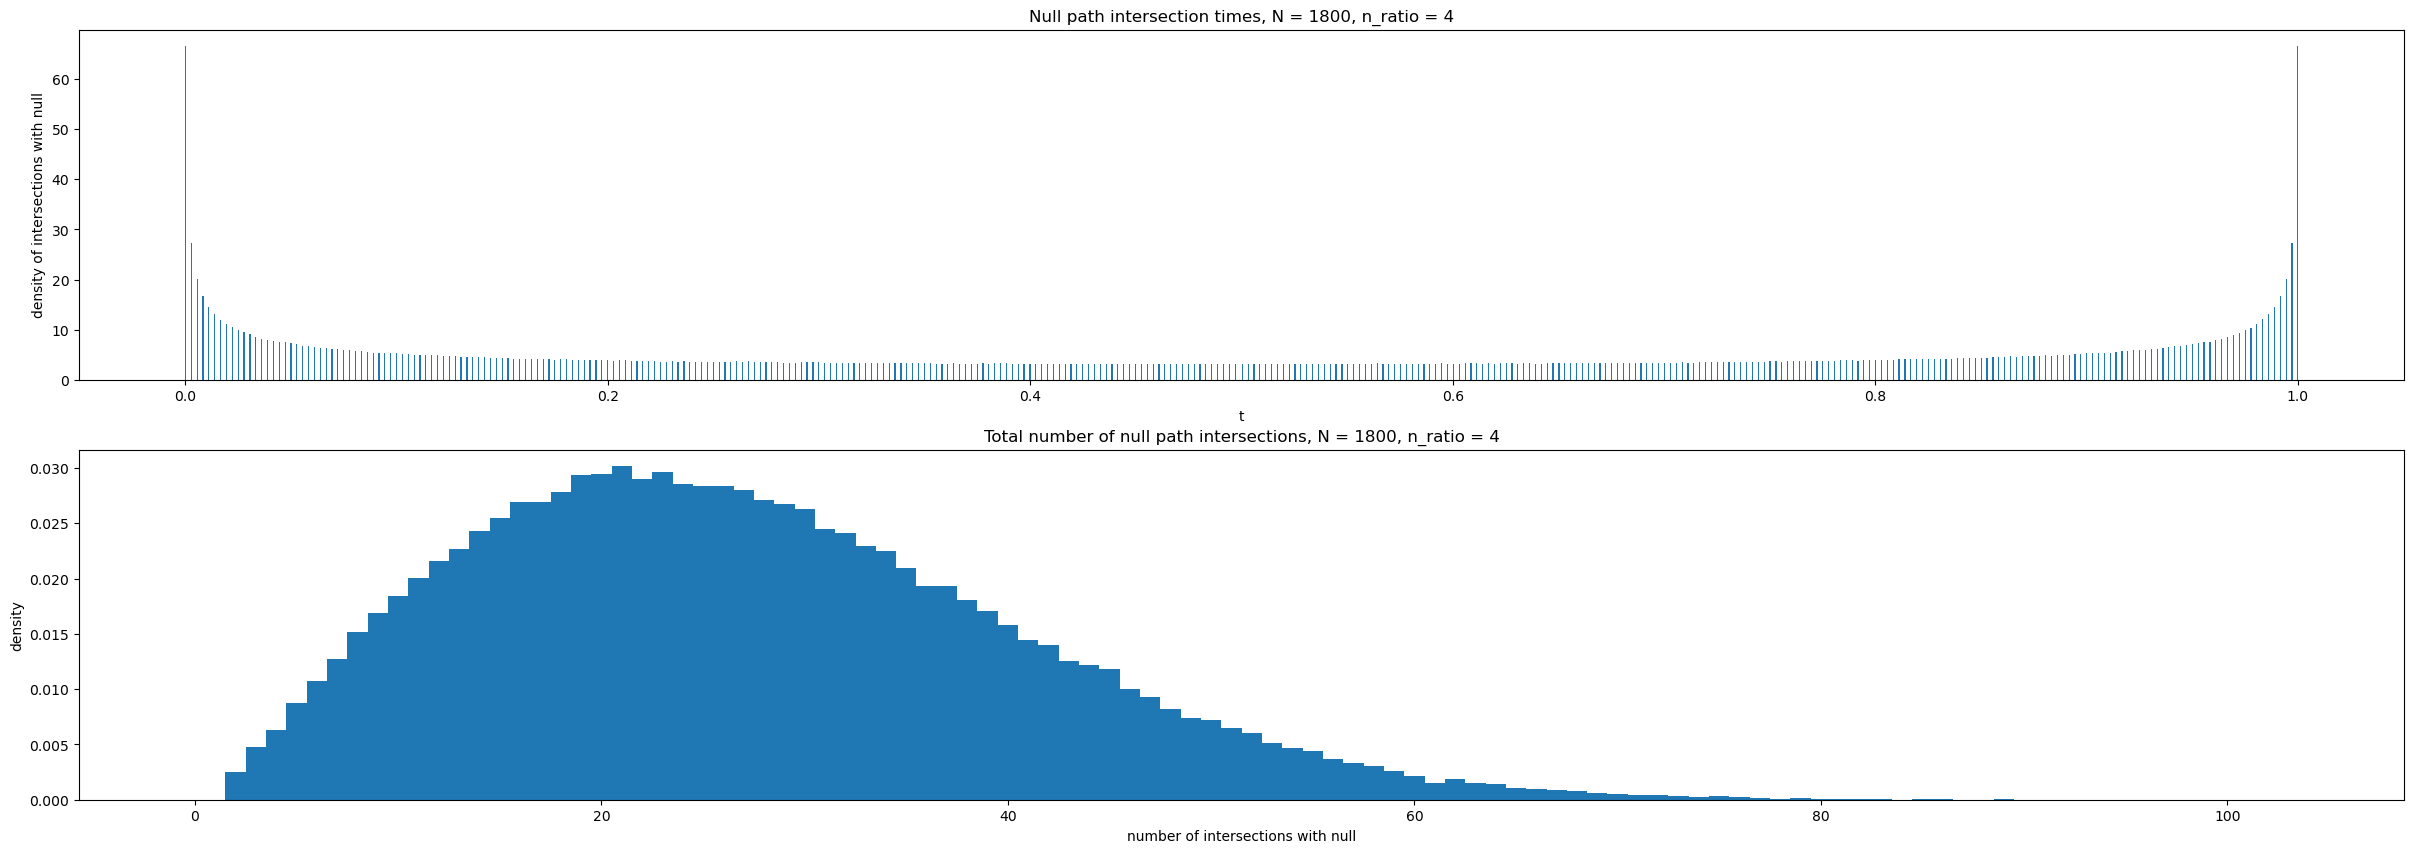

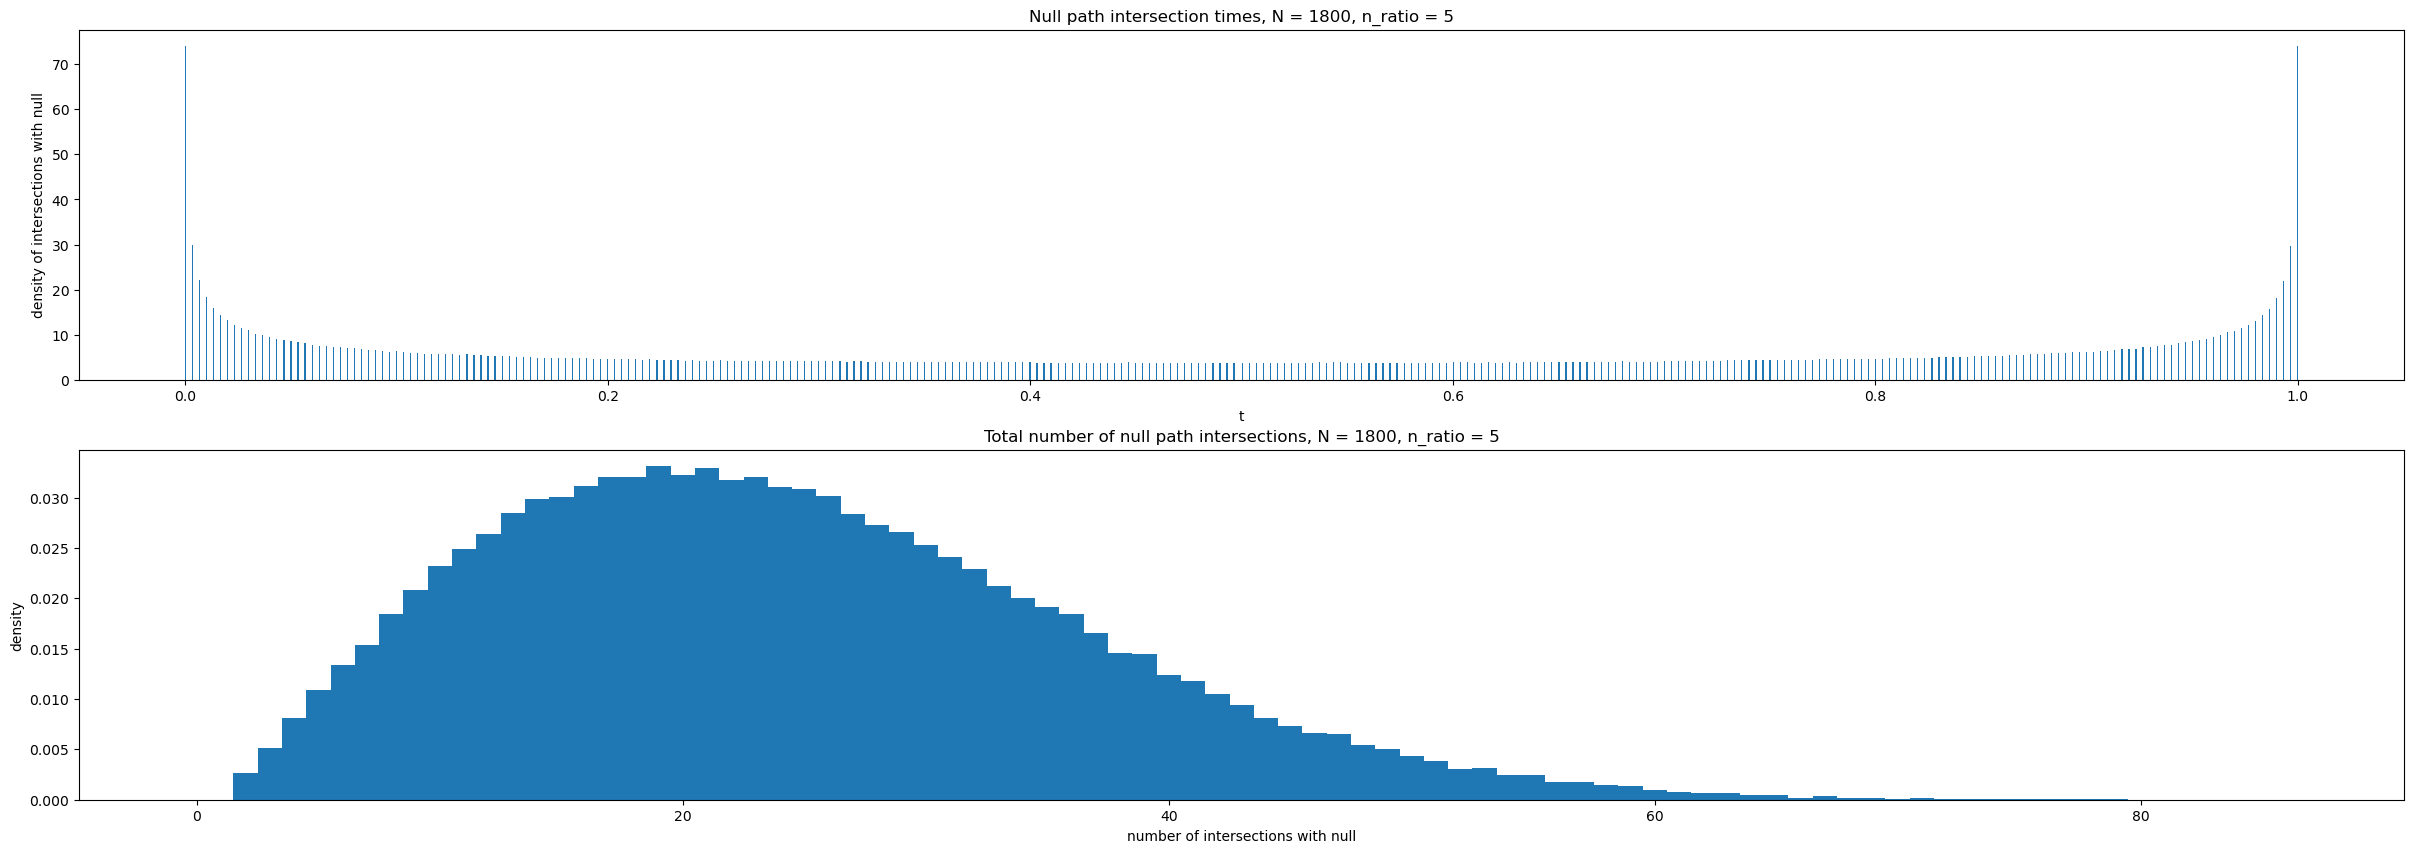

In [ ]:
for i in range(len(N1)):
    for j in range(len(n_ratios)):
        inters, inter_number = runs[i][j]
        N = N1[i]
        n_ratio = n_ratios[j]
        fig, axs = plt.subplots(2,1)
        fig.set_figwidth(30)
        fig.set_figheight(10)
        axs[0].hist(inters, bins = N+2, density = True, range = [- 0.5 / N, 1 + 0.5/N])
        axs[0].set_title(f"Null path intersection times, N = {N}, n_ratio = {n_ratio}")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("density of intersections with null")
        
        axs[1].hist(inter_number, bins = np.max(inter_number) + 1, density = True, range = [-0.5, np.max(inter_number) + 0.5])
        # axs[1].bar(np.arange(len(inter_number)), inter_number)

        axs[1].set_title(f"Total number of null path intersections, N = {N}, n_ratio = {n_ratio}")
        axs[1].set_xlabel("number of intersections with null")
        axs[1].set_ylabel("density")
        plt.show()

mean of mean recurrence times = 0.057686012629266946


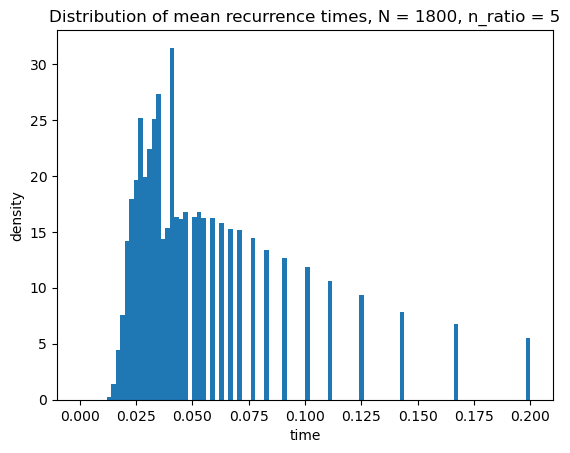

In [14]:
mean_recurrences = 1 / inter_number
print(f'mean of mean recurrence times = {np.mean(mean_recurrences)}')

fig, ax = plt.subplots()
ax.hist(mean_recurrences, bins = 100, density = True, range = [0,0.2])
ax.set_title(f"Distribution of mean recurrence times, N = {N}, n_ratio = {n_ratio}")
ax.set_xlabel("time")
ax.set_ylabel("density")
plt.show()

In [15]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

def parametric(n_ratio, N, ax, c = None):

    x = gillespie(n_ratio, N).get()[0]
    seq = np.array(x[1:] < x[:-1]) * 1
    parametric = [[0],[0]]
    for i in seq:
        parametric[i].append(parametric[i][-1] + 1)
        parametric[i-1].append(parametric[i-1][-1])
    parametric = np.array(parametric) / N
    
    ax.plot(parametric[0], parametric[1], label = f' +/- ratio={n_ratio}', c=c)
    ax.set_title("Path in parametric axes")
    ax.set_xlabel("x+")
    ax.set_ylabel("x-")
    return parametric

def parametric_shifted(n_ratio, N, path, ax):
    Ns = [int(n_ratio * N / (n_ratio + 1))]
    Ns.append(N-Ns[0])

    # shift by null path
    t = np.linspace(0, 1, N+1)
    shift_plus = Ns[0] / N * t
    shift_minus = Ns[1] / N * t
    x = path[0] - shift_plus
    y = path[1] - shift_minus


    points = np.array([x, y]).transpose().reshape(-1, 1, 2)
    # set up a list of segments
    # segs = np.concatenate([points[:-1],points[1:]],axis=1)
    segs = np.concatenate([points[:-2], points[1:-1], points[2:]], axis=1)

    # make the collection of segments
    lc = LineCollection(segs, cmap=plt.get_cmap('viridis'))

    lc.set_array(t)  # color the segments by our parameter

    # plot the collection

    ax.add_collection(lc)  # add the collection to the plot

    a = list(ax.get_xlim())
    b = list(ax.get_ylim())
    a = [np.min([a[0], x.min()]), np.max([a[1], x.max()])]
    b = [np.min([b[0], y.min()]), np.max([b[1], y.max()])]

    ax.set_xlim(a)
    ax.set_ylim(b)

    ax.set_title("Parametric path shifted by null path")
    ax.set_xlabel("y+")
    ax.set_ylabel("y-")

    return np.array([x, y])

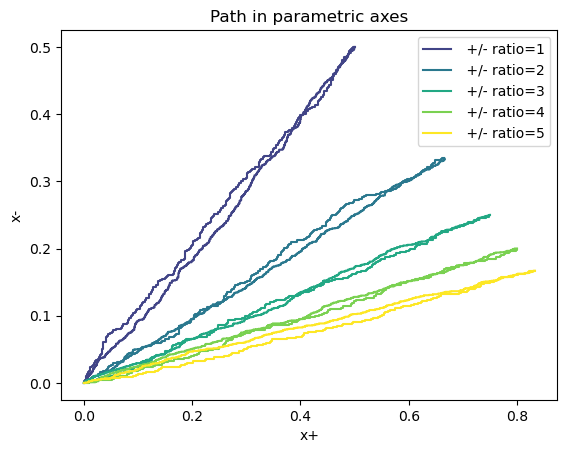

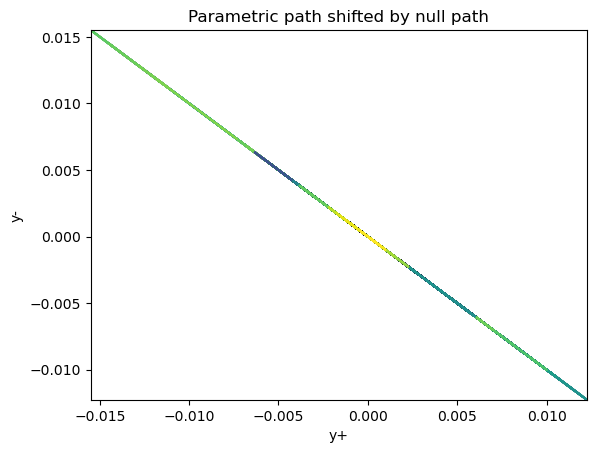

In [16]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
ax2.set_xlim(-0.001,0.001)
ax2.set_ylim(-0.001,0.001)

paths = []
shifted = []
n_ratios = [i for i in range(1,6)]
N1 = [1000 * i for i in range(1,3)]

c = plt.cm.viridis(n_ratios / np.max(n_ratios))

for N in N1:
    paths.append([])
    shifted.append([])
    for j in range(len(n_ratios)):
        paths[-1].append(parametric(n_ratios[j], N, ax1, c=c[j]))
        shifted[-1].append(parametric_shifted(n_ratios[j], N, paths[-1][-1], ax2))
legend_without_duplicate_labels(ax1)
plt.show()

(5, 1001)


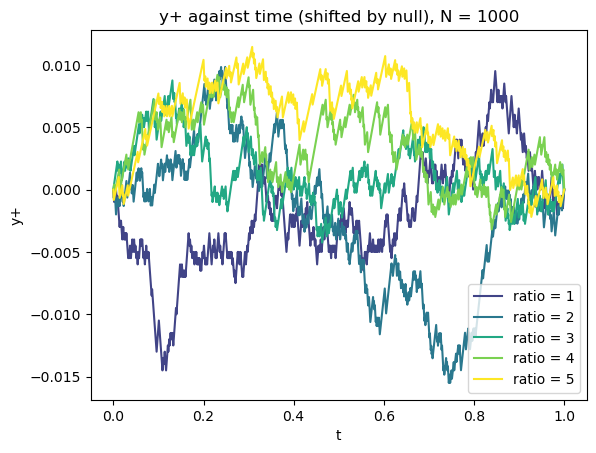

(5, 2001)


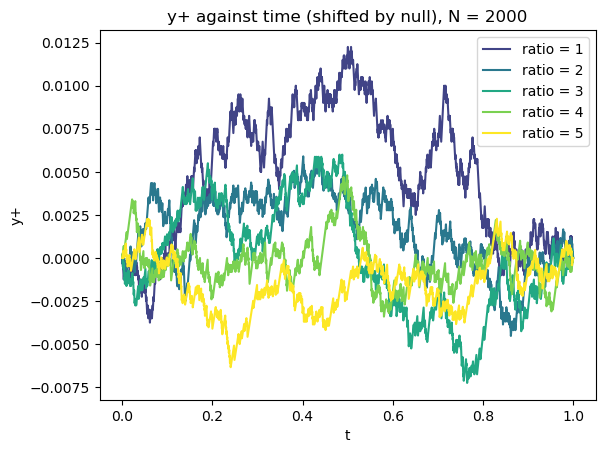

In [17]:
for i in range(len(N1)):
    shifted_plus = np.transpose(shifted[i], [1,0,2])[0]

    print(np.shape(shifted_plus))
    # print(np.shape(np.transpose(shifted[i])))
    t = np.linspace(0, 1, N1[i]+1)
    for j in range(len(n_ratios)):
        plt.plot(t, shifted_plus[j], label = f'ratio = {n_ratios[j]}', c = c[j])

    plt.xlabel("t")
    plt.ylabel("y+")
    plt.title(f"y+ against time (shifted by null), N = {N1[i]}")
    legend_without_duplicate_labels(plt.gca())
    plt.show()